# Expressive Guitar Technique classifier
Ph.D. research project of [Domenico Stefani](work.domenicostefani.com)  
This notebook loads a dataset of feature vectors extracted from **pitched** and **percussive** sounds recorded with many acoustic guitars.
The techniques/classes recorded are:  

0.    **Kick**      (Palm on lower body)
1.    **Snare 1**   (All fingers on lower side)
2.    **Tom**       (Thumb on higher body)
3.    **Snare 2**   (Fingers on the muted strings, over the end
of the fingerboard)
___
4.    **Natural Harmonics** (Stop strings from playing the dominant frequency, letting harmonics ring)
5.    **Palm Mute** (Muting partially the strings with the palm
of the pick hand)
6.    **Pick Near Bridge** (Playing toward the bridge/saddle)
7.    **Pick Over the Soundhole** (Playing over the sound hole)


## Import modules and mount drive folder

In [1]:
# Choose ClassificationTask task
from enum import Enum
class ClassificationTask(Enum):
    FULL_8_CLASS_PROBLEM,BINARY_PERCUSSIVE_PITCHED,PERCUSSIVE_4_ONLY,PITCHED_4_ONLY,PERCUSSIVE_PLUS_PITCHED_CLASS,ONE_GUITARIST_FULL = ((1,'full'), (2,'binary'), (3,'perc'), (4,'pitch'), (5,'perc+pitch'), (6,'one-guit-full'))
class FeatureSelection(Enum):
    NONE,MANUAL_VARIABLES,MANUAL_LIST,AUTO_ANOVA,AUTO_RELIEF = (0, 1, 2, 3, 4)
class FeatureWindowSize(Enum):
    s4800_SAMPLES_100ms, s704_Samples_14ms = (1, 2)

In [2]:
classification_task = ClassificationTask.FULL_8_CLASS_PROBLEM
# classification_task = ClassificationTask.BINARY_PERCUSSIVE_PITCHED
# classification_task = ClassificationTask.PERCUSSIVE_4_ONLY
# classification_task = ClassificationTask.PERCUSSIVE_PLUS_PITCHED_CLASS
# classification_task = ClassificationTask.ONE_GUITARIST_FULL

# FEATURE_SELECTION = FeatureSelection.MANUAL_VARIABLES
# FEATURE_SELECTION = FeatureSelection.MANUAL_LIST
FEATURE_SELECTION = FeatureSelection.AUTO_ANOVA #ANOVA: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html
# FEATURE_SELECTION = FeatureSelection.AUTO_RELIEF

# FEATURE_WINDOW_SIZE = FeatureWindowSize.s4800_SAMPLES_100ms
FEATURE_WINDOW_SIZE = FeatureWindowSize.s704_Samples_14ms
DROP_ADDITIONAL_CEPSTRUM_FROM_BIG_WINDOW = True

# SCALER_TO_USE = 'StandardScaler'
SCALER_TO_USE = 'MinMaxScaler'

#import sklearn scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
if SCALER_TO_USE == 'StandardScaler':
    SCALER_TO_USE = StandardScaler()
elif SCALER_TO_USE == 'MinMaxScaler':
    SCALER_TO_USE = MinMaxScaler()

TRAIN_FINAL_MODEL = False

In [3]:
# Install module for the ReliefF feature selection
# !pip install skrebate
# !pip install tensorboard
# !pip3 install pickle5
# !pip3 install tensorflow==2.4.1
# !pip3 install tensorboard

In [4]:
REQUIRE_GPU = False
DO_SAVE_TENSORBOARD_LOGS = False 
DO_SAVE_FOLD_MODELS = False 
CUSTOM_PLAYER_K_FOLD = True         # Very important, this ditches the k-fold stratified random shuffle, and creates as many splits as the guitar players, separating natural groups
DROP_EXTRA_PERCUSSIVE_SOUNDS = True # If true, drop the data from files that have 'extra' in the filename, which otherwise make the dataset unbalanced


USE_TENSORBOARD = False

if FEATURE_WINDOW_SIZE == FeatureWindowSize.s4800_SAMPLES_100ms:
    USE_AUGMENTED_DATA = False
elif FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms:
    USE_AUGMENTED_DATA = True
else:
    raise ValueError('Invalid feature window size')
# USE_AUGMENTED_DATA = False
DROP_EXTRA_PERCUSSIVE_SOUNDS_FROMAUG = False

DO_NORMALIZE_DATA = True

DO_NORMALIZE_FOR_FEATURE_SELECTION = True

# Load the TensorBoard notebook extension
if USE_TENSORBOARD:
    %load_ext tensorboard

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from sys import executable as sys_executable
from sys import argv as sys_argv
import pandas as pd
import numpy as np
import tensorflow as tf
from time import strftime, time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from bz2 import BZ2File # To open compressed data
import re
import shutil
import imblearn
from sklearn.metrics import confusion_matrix as sk_conf_matrix
from sklearn.metrics import classification_report as sk_class_report

print("Tensorflow version: " + tf.version.VERSION)
print('Imblearn version:',imblearn.__version__)

global_random_state = 42
np.random.seed(global_random_state)
tf.random.set_seed(global_random_state)

COLAB = 'google.colab' in str(get_ipython())

if COLAB:
    print('Running on CoLab')
    #Connect and mount the drive folder that contains the train dataset and the output folder
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=False)

    HOMEBASE = os.path.join('/content','gdrive','MyDrive','dottorato','Publications','02-IEEE-RTEmbeddedTimbreClassification(submitted)','Classifier')
    THISDIR = "/content/"
else:
    print('Not running on CoLab')
    HOMEBASE = "."
    THISDIR = "./"
DATAFOLDER = os.path.join(HOMEBASE,"data/phase3")
MODELFOLDER = os.path.join(HOMEBASE,"output")

RELIEF_CACHE_FILEPATH = os.path.join(DATAFOLDER,'relief_cache.pickle')


Tensorflow version: 2.5.0
Imblearn version: 0.9.0
Not running on CoLab


In [5]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

## Enforce GPU usage

In [6]:
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
physical_devices = tf.config.list_physical_devices('GPU') 

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

print(physical_devices)
if REQUIRE_GPU:
  assert len(tf.config.experimental.list_physical_devices('GPU')) >= 1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Check Real avaliable GRAM

In [7]:
import subprocess
import sys

def pip_install(package):
    subprocess.check_call([executable, "-m", "pip", "install", package])

In [8]:
CHECK_GRAM = False

if CHECK_GRAM:
    # memory footprint support libraries/code
    os.symlink('/opt/bin/nvidia-smi','/usr/bin/nvidia-smi')
    pip_install('gputil')
    pip_install('psutil')
    pip_install('humanize')
    import psutil
    import humanize
    import os
    import GPUtil as GPU
    GPUs = GPU.getGPUs()
    # XXX: only one GPU on Colab and isn’t guaranteed
    gpu = GPUs[0]
    def printm():
        process = psutil.Process(os.getpid())
        print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    printm()

# Import Dataset

In [10]:
if FEATURE_WINDOW_SIZE == FeatureWindowSize.s4800_SAMPLES_100ms:
    DATASET_FILENAME = 'onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20221206-165551_SUPERLONGdataset-phase3PROCESSED_FEATURES.pickle'
elif FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms:
    DATASET_FILENAME = 'onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20221201-182312_REALTIMEdataset-phase3PROCESSED_FEATURES.pickle'
else:
    raise ValueError('Invalid FeatureWindowSize "%s"'%FeatureWindowSize.name)

print('Loading dataset from file:',DATASET_FILENAME)


if os.path.splitext(DATASET_FILENAME)[1] == '.bz2':
    print("Reading dataset from compressed pickle...")
    DATASET_PATH = os.path.join(DATAFOLDER,DATASET_FILENAME)
    startime = time()
    ifile = BZ2File(DATASET_PATH,'rb')
    featuredataset = pickle.load(ifile)
    ifile.close()
    print('Successfully Loaded!\nIt took %.1fs to load from compressed pickle' % (time()-startime))
elif os.path.splitext(DATASET_FILENAME)[1] == '.pickle':
    print("Reading dataset from pickle...")
    DATASET_PATH = os.path.join(DATAFOLDER,DATASET_FILENAME)
    startime = time()
    with open(DATASET_PATH,'rb') as pf:
        featuredataset = pickle.load(pf)
    print('Successfully Loaded!\nIt took %.1fs to load from regular pickle' % (time()-startime))
else:
    raise Exception("Extension %s not supported!" % os.path.splitext(DATASET_FILENAME)[1])
print('Dataset loaded!')
# display(featuredataset)

Loading dataset from file: onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20221201-182312_REALTIMEdataset-phase3PROCESSED_FEATURES.pickle
Reading dataset from pickle...
Successfully Loaded!
It took 1.0s to load from regular pickle
Dataset loaded!


In [11]:
EXPECTED_DATASED_SIZE = 23303

In [12]:
from glob import glob
augmented_featuredataset_list = []
if USE_AUGMENTED_DATA:
    augmented_data_paths = glob(os.path.join(DATAFOLDER,'augmented_data','*.pickle'))
    for augmented_data_path in augmented_data_paths:
        print("Loading file %s" % os.path.basename(augmented_data_path))
        with open(augmented_data_path,'rb') as pf:
            augmented_featuredataset_list.append(pickle.load(pf))
    augmented_featuredataset = pd.concat(augmented_featuredataset_list, ignore_index=True)
    print("Loaded %d augmented samples" % len(augmented_featuredataset))

Loading file metaplus_onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20221125-144015_gainaug-phase3-aug1PROCESSED_FEATURES.pickle
Loading file metaplus_onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20221125-163857_gainaug-phase3-aug4PROCESSED_FEATURES.pickle
Loading file metaplus_onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20221125-152410_gainaug-phase3-aug2PROCESSED_FEATURES.pickle
Loading file metaplus_onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20221125-160225_gainaug-phase3-aug3PROCESSED_FEATURES.pickle
Loaded 92293 augmented samples


### Drop features that we have found to be problematic with feature selection and training

In [13]:
def drop_unused_features(features_df: pd.DataFrame, inplace = False) -> pd.DataFrame:
    if not inplace:
        res_df = features_df.copy()
    else:
        res_df = features_df
    if 'attackTime_peaksamp'       not in res_df.columns.to_list() or\
       'attackTime_attackStartIdx' not in res_df.columns.to_list() or\
       'peakSample_index'          not in res_df.columns.to_list():
       raise Exception("The features dataframe does not contain the required columns!")

    res_df.drop(columns=['attackTime_peaksamp',\
                                'attackTime_attackStartIdx',\
                                'peakSample_index'], inplace=True)
    return res_df

featuredataset = drop_unused_features(featuredataset)
if USE_AUGMENTED_DATA:
    augmented_featuredataset = drop_unused_features(augmented_featuredataset)



In [14]:
if DROP_ADDITIONAL_CEPSTRUM_FROM_BIG_WINDOW:

    # Largest cepstrum now:
    larg_ceps = max([int(e.split('_')[-1]) for e in featuredataset.columns.to_list() if 'cepstrum' in e])
    # Max xepstrum coeff. of smallest window (704 samples)
    smallest_ceps = 704//2+1

    featuredataset.drop(columns=[f'cepstrum_{v}' for v in range(smallest_ceps+1,larg_ceps + 1)], inplace=True)

In [15]:
featuredataset.columns

Index(['meta_audiofilePath', 'meta_onsetGroundTruthLabelTime',
       'meta_onsetDetectionTime', 'meta_featureComputationTime',
       'meta_featureExtractionWindowSize', 'meta_sampleRate', 'meta_blockSize',
       'meta_extractiondate', 'meta_expressive_technique_id',
       'attackTime_value',
       ...
       'mfcc_31', 'mfcc_32', 'mfcc_33', 'mfcc_34', 'mfcc_35', 'mfcc_36',
       'mfcc_37', 'mfcc_38', 'peakSample_value', 'zeroCrossing'],
      dtype='object', length=504)

### If specified, drop extra percussive recorded data

In [16]:
if FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms:
    assert featuredataset.shape == (EXPECTED_DATASED_SIZE, 504)
if DROP_EXTRA_PERCUSSIVE_SOUNDS:
    to_drop_count = np.count_nonzero(featuredataset.meta_audiofilePath.str.contains("additional-500").values)
    if to_drop_count >= 0:
        print('Dropping %d additional percussive recordings because "DROP_EXTRA_PERCUSSIVE_SOUNDS" was specified.'%(to_drop_count))
        featuredataset = featuredataset[~featuredataset.meta_audiofilePath.str.contains("additional-500")].reset_index(drop=True)
        print('Dataset shape after dropping extra percussive recordings: %s'%(str(featuredataset.shape)))
    if FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms:
        assert featuredataset.shape == (EXPECTED_DATASED_SIZE-2237, 504)


if USE_AUGMENTED_DATA and DROP_EXTRA_PERCUSSIVE_SOUNDS_FROMAUG:
    augmented_featuredataset_dr = augmented_featuredataset.copy()
    to_drop_count_aug = np.count_nonzero(augmented_featuredataset.meta_augmentation_source.str.contains("additional-500").values)
    if to_drop_count_aug >= 0:
        print('Dropping %d additional percussive recordings because "DROP_EXTRA_PERCUSSIVE_SOUNDS" was specified.'%(to_drop_count_aug))
        augmented_featuredataset_dr = augmented_featuredataset[~augmented_featuredataset.meta_augmentation_source.str.contains("additional-500")].reset_index(drop=True)
        print('Dataset shape after dropping extra percussive recordings: %s'%(str(augmented_featuredataset_dr.shape)))

Dropping 2237 additional percussive recordings because "DROP_EXTRA_PERCUSSIVE_SOUNDS" was specified.
Dataset shape after dropping extra percussive recordings: (21066, 504)


In [17]:
# Extract separate DFs
from typing import Tuple

# Divide dataset into metadata, features and labels
def divide_dataset(features_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    metadata = features_df.filter(regex='^meta_',axis=1)
    labels = features_df.meta_expressive_technique_id
    features = features_df.loc[:,[col for col in features_df.columns if col not in metadata.columns]]
    # Convert to numeric formats where possible (somehow convert_dtypes doesn't work [https://stackoverflow.com/questions/65915048/pandas-convert-dtypes-not-working-on-numbers-marked-as-objects])
    metadata = metadata.apply(pd.to_numeric, errors='ignore')
    labels = labels.apply(pd.to_numeric, errors='ignore')
    features = features.apply(pd.to_numeric, errors='ignore')
    return metadata, features, labels

metadata, features, labels = divide_dataset(featuredataset)
assert metadata.shape[1] == 9
if FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms:
    assert features.shape[1] == 495
elif FEATURE_WINDOW_SIZE == FeatureWindowSize.s4800_SAMPLES_100ms:
    assert features.shape[1] == 2543

if USE_AUGMENTED_DATA:
    metadata_aug, features_aug, labels_aug = divide_dataset(augmented_featuredataset_dr if DROP_EXTRA_PERCUSSIVE_SOUNDS_FROMAUG else augmented_featuredataset)

In [18]:
def get_classes_description(classftask: ClassificationTask):
    if classification_task == ClassificationTask.FULL_8_CLASS_PROBLEM:
        classes_desk = {0:"Kick",1:"Snare 1",2:"Tom",3:"Snare 2",4:"Natural Harmonics",5:"Palm Mute",6:"Pick Near Bridge",7:"Pick Over the Soundhole"}
    elif classification_task == ClassificationTask.BINARY_PERCUSSIVE_PITCHED:
        classes_desk = {0:"Percussive",1:"Pitched"}
    elif classification_task == ClassificationTask.PERCUSSIVE_4_ONLY:
        classes_desk = {0:"Kick", 1:"Snare 1", 2:"Tom", 3:"Snare 2"}
    elif classification_task == ClassificationTask.PITCHED_4_ONLY:
        classes_desk = {0:"Natural Harmonics", 1:"Palm Mute", 2:"Pick Near Bridge", 3:"Pick Over the Soundhole"}
    elif classification_task == ClassificationTask.PERCUSSIVE_PLUS_PITCHED_CLASS:
        classes_desk = {0:"Kick", 1:"Snare 1", 2:"Tom", 3:"Snare 2", 4:"Pitched"}
    elif classification_task == ClassificationTask.ONE_GUITARIST_FULL:
        classes_desk = {0:"Kick",1:"Snare 1",2:"Tom",3:"Snare 2",4:"Natural Harmonics",5:"Palm Mute",6:"Pick Near Bridge",7:"Pick Over the Soundhole"}
    else:
        raise Exception('The Classification Task selected is not supported')
    classes = list(classes_desk.keys())
    return classes,classes_desk

def filter_dataset(tofilt_features,tofilt_labels,tofilt_metadata,classftask: ClassificationTask, hardcoded_sizes_test = False):
    if classification_task == ClassificationTask.FULL_8_CLASS_PROBLEM:
        pass
    elif classification_task == ClassificationTask.BINARY_PERCUSSIVE_PITCHED:
        assert len(tofilt_features) == len(tofilt_labels)
        if hardcoded_sizes_test:
            assert len(tofilt_features) == EXPECTED_DATASED_SIZE-2237
        tofilt_labels = tofilt_labels.replace([0,1,2,3],[0,0,0,0])
        tofilt_labels = tofilt_labels.replace([4,5,6,7],[1,1,1,1])
    elif classification_task == ClassificationTask.PERCUSSIVE_4_ONLY:
        assert len(tofilt_features) == len(tofilt_labels)
        if hardcoded_sizes_test:
            assert len(tofilt_features) == EXPECTED_DATASED_SIZE-2237
        filtered_idxs = tofilt_labels < 4
        tofilt_features = tofilt_features[filtered_idxs]
        tofilt_labels = tofilt_labels[filtered_idxs]
        tofilt_metadata = tofilt_metadata[filtered_idxs].copy()
        assert len(tofilt_features) == len(tofilt_labels)
        if hardcoded_sizes_test:
            assert len(tofilt_features) == 1620
    elif classification_task == ClassificationTask.PITCHED_4_ONLY:
        assert len(tofilt_features) == len(tofilt_labels)
        if hardcoded_sizes_test:
            assert len(tofilt_features) == EXPECTED_DATASED_SIZE-2237
        filtered_idxs = tofilt_labels >= 4
        tofilt_features = tofilt_features[filtered_idxs]
        tofilt_metadata = tofilt_metadata[filtered_idxs].copy()
        tofilt_labels = tofilt_labels[filtered_idxs]
        tofilt_labels = tofilt_labels.replace([4,5,6,7],[0,1,2,3])
        assert len(tofilt_features) == len(tofilt_labels)
        if hardcoded_sizes_test:
            assert len(tofilt_features) == EXPECTED_DATASED_SIZE-2237-1620
    elif classification_task == ClassificationTask.PERCUSSIVE_PLUS_PITCHED_CLASS:
        assert len(tofilt_features) == len(tofilt_labels)
        if hardcoded_sizes_test:
            assert len(tofilt_features) == EXPECTED_DATASED_SIZE-2237
        tofilt_labels = tofilt_labels.replace([5,6,7],[4,4,4])
    elif classification_task == ClassificationTask.ONE_GUITARIST_FULL:

        filtered_idxs = tofilt_features['']
        # tofilt_features = tofilt_features[filtered_idxs]
        # tofilt_labels = tofilt_labels[filtered_idxs]
        # tofilt_metadata = tofilt_metadata[filtered_idxs].copy()
        # assert len(tofilt_features) == len(tofilt_labels)
        # if hardcoded_sizes_test:
        #     assert len(tofilt_features) == 1620
    else:
        raise Exception('The Classification Task selected is not supported')


    tofilt_features.reset_index(drop=True,inplace=True)
    tofilt_labels.reset_index(drop=True,inplace=True)
    tofilt_metadata.reset_index(drop=True,inplace=True)

    return tofilt_features, tofilt_labels, tofilt_metadata

original_dataset_features = features.copy()
dataset_labels = labels.copy()
dataset_metadata = metadata.copy()

CLASSES,CLASSES_DESC = get_classes_description(classification_task)
original_dataset_features,dataset_labels,dataset_metadata = filter_dataset(original_dataset_features,dataset_labels,dataset_metadata,classification_task,hardcoded_sizes_test=True if FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms else False)
if USE_AUGMENTED_DATA:
    features_aug,labels_aug,metadata_aug = filter_dataset(features_aug,labels_aug,metadata_aug,classification_task,hardcoded_sizes_test=False)
    assert len(np.sort(CLASSES)) == len(np.sort(pd.unique(labels_aug))) and np.equal(np.sort(CLASSES),np.sort(pd.unique(labels_aug))).all()

assert len(np.sort(CLASSES)) == len(np.sort(pd.unique(dataset_labels))) and np.equal(np.sort(CLASSES),np.sort(pd.unique(dataset_labels))).all()

In [19]:
print(metadata[metadata['meta_audiofilePath'].str.contains('LucTur2')]['meta_audiofilePath'].values)

['acoustic_guitar_percussive_keybed_1_25_f_LucTur2_20201215.wav'
 'acoustic_guitar_percussive_keybed_1_25_f_LucTur2_20201215.wav'
 'acoustic_guitar_percussive_keybed_1_25_f_LucTur2_20201215.wav' ...
 'acoustic_guitar_pitched_allstring6_soundholepick_p_LucTur2_20201215.wav'
 'acoustic_guitar_pitched_allstring6_soundholepick_p_LucTur2_20201215.wav'
 'acoustic_guitar_pitched_allstring6_soundholepick_p_LucTur2_20201215.wav']


In [20]:
if USE_AUGMENTED_DATA:
    for dat,name in [(original_dataset_features,'Main datase'),(features_aug,'Augmented data')]:
        print('Dataset "'+name+'" read')
        print("| Entries: "+str(dat.shape[0]))
        print("╰─ Features: "+str(dat.shape[1]))

original_feature_number = original_dataset_features.shape[1]

Dataset "Main datase" read
| Entries: 21066
╰─ Features: 495
Dataset "Augmented data" read
| Entries: 92293
╰─ Features: 495


In [21]:
# Compute has of the dataset files.
# This are used to cache precomputed feature selection with ReliefF (Which is rather slow)
import hashlib
 
dataset_sha256_hash = hashlib.sha256()
with open(DATASET_PATH,"rb") as fy:
    for byte_block in iter(lambda: fy.read(4096),b""):    # Read and update hash string value in blocks of 4K
        dataset_sha256_hash.update(byte_block)
dataset_sha256_hash = dataset_sha256_hash.hexdigest()

print(dataset_sha256_hash)

4aa23cac1ee24f27bb04f4aa5631e99329a3a965b9ba960aee8f8c65880c289f


## Parse Command Line arguments

*_Important_*: If you are running this from a jupyter Notebook, change the run parameters at the end of the next cell

In [ ]:
args = None
if not is_notebook() and not COLAB:
    import argparse
    parser = argparse.ArgumentParser(description='Train the expressive guitar technique classifier.')

    def featnum_type(x):
        (MIN,MAX) = (1,495)
        if x == 'all':
            return x
        x = int(x)
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Feature parameter must either 'all' or a number be between {} and {}".format(MIN, MAX))
        return x
    def netdepth_type(x):
        (MIN,MAX) = (0,20) 
        x = int(x)
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Network depth must be between {} and {}".format(MIN, MAX))
        return x
    def netwidth_type(x):
        (MIN,MAX) = (1,2000) 
        x = int(x)
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Network width must be between {} and {}".format(MIN, MAX))
        return x
    def dropout_type(x):
        (MIN,MAX) = (0,1) 
        x = float(x)
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Dropout Rate must be between {} and {}".format(MIN, MAX))
        return x
    def aggressiveness_type(x):
        (MIN,MAX) = (0,1) 
        x = float(x)
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Oversampling aggressiveness value must be between {} and {}".format(MIN, MAX))
        return x
    def lr_type(x):
        (MIN,MAX) = (0,1) 
        x = float(x)
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Learning rate must be between {} and {}".format(MIN, MAX))
        return x
    def batchsize_type(x):
        (MIN,MAX) = (1,4096) 
        x = int(x)
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Batchsize must be between {} and {}".format(MIN, MAX))
        return x
    def epochs_type(x):
        (MIN,MAX) = (1,10000) 
        x = int(x)
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Epoch number must be between {} and {}".format(MIN, MAX))
        return x
    def kfold_type(x):
        (MIN,MAX) = (1,20) 
        x = int(x)
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("KFOLD size must be between {} and {}".format(MIN, MAX))
        return x
    def c1d_type(x):
        (MIN,MAX) = (0,5) 
        x = int(x)
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Number of conv1d layers must be between {} and {}".format(MIN, MAX))
        return x

    # class RangedInt():


    # def ranged_int_type(x,_min,_max):
    #     x = int(x)
    #     if x < _min or x > _max:
    #         raise argparse.ArgumentTypeError("Value must be an integer number between {} and {}".format(_min, _max))
    #     return x

    # def ranged_float_type(x,_min,_max):
    #     x = float(x)
    #     if x < _min or x > _max:
    #         raise argparse.ArgumentTypeError("Value must be a real number between {} and {}".format(_min, _max))
    #     return x

    parser.add_argument('-f',  '--features',      default='all',     type=featnum_type,   help='Number of features to use for training [1-495] (default: 80)')
    parser.add_argument('-d',  '--net-depth',     default=3,      type=netdepth_type,  help='Number of dense layers in the network [0-20] (default: 3)')
    parser.add_argument('-w',  '--net-width',     default=100,    type=netwidth_type,  help='Number of layers in the FFNN [1-2000] (default: 100)')
    parser.add_argument('-dr', '--dropout',       default=0.15,   type=dropout_type,   help='Dropout amount [0-1] (default: 0.15)')
    parser.add_argument('-lr', '--learning-rate', default=0.0001, type=lr_type,        help='Learning rate [0-1] (default: 0.0001)')
    parser.add_argument('-bs', '--batchsize',     default=256,    type=batchsize_type, help='Learning rate [1-4096] (default: 256)')
    parser.add_argument('-e',  '--epochs',        default=1000,   type=epochs_type,    help='Learning rate [1-10000] (default: 1000)')
    parser.add_argument('-k',  '--k-folds',       default=5,      type=kfold_type,     help='K of K-folds [1-20] (default: 5)')
    parser.add_argument('-os', '--oversampling',  action='store_true', help='Perform oversampling')
    parser.add_argument('-osagg', '--oversampling-aggressiveness',  default=0.2,   type=aggressiveness_type,   help='Oversampling aggressiveness [0-1] (default: 0.2)')
    parser.add_argument('-c1d',   '--conv1d',     default=0,      type=c1d_type,     help='Number of conv1D layers at the beginning [1-5] (default: 0)')
    parser.add_argument('-ck',    '--conv1d-kernels',     default='',      type=ascii,     help='Comma-separated list of kernel sizes for conv1D layers (es: 3,5,7)')
    parser.add_argument('-cs',    '--conv1d-strides',     default='',      type=ascii,     help='Comma-separated list of strides for conv1D layers (es: 1,1,1)')
    parser.add_argument('-cf',    '--conv1d-filters',     default='',      type=ascii,     help='Comma-separated list of filters for conv1D layers (es: 32,64,128)')
    parser.add_argument('-c1dact','--conv1d-activations', default='',  type=ascii,     help='Comma-separated list of activations for conv1D layers (es: relu,relu,relu)')
    parser.add_argument('-pl','--pool_layers', default='',  type=ascii,     help='Comma-separated list of pool layers. Use "N" for none, "M" for max-pooling and "A" for average pooling  (es: M,N,M)')
    parser.add_argument('-v', '--verbose',        action='store_true', help='increase output verbosity')
    args = parser.parse_args()
    args = vars(args)
else:

    """
    ████████████████████████████████████████████████████████████████████████████████████████████████████
    █████████████████████████████     ██     ██     ██     ██ ███ ██     ███████████████████████████████
    █████████████████████████████ ███ ██ ███ ██ ███ ██ ███ ██  █  ██ ███████████████████████████████████
    █████████████████████████████ ███ ██ ███ ██ ███ ██ ███ ██ █ █ ██ ███████████████████████████████████
    █████████████████████████████     ██     ██     ██     ██ ███ ██     ███████████████████████████████
    █████████████████████████████ ██████ ███ ██ ██ ███ ███ ██ ███ ██████ ███████████████████████████████
    █████████████████████████████ ██████ ███ ██ ███ ██ ███ ██ ███ ██████ ███████████████████████████████
    █████████████████████████████ ██████ ███ ██ ███ ██ ███ ██ ███ ██     ███████████████████████████████
    ████████████████████████████████████████████████████████████████████████████████████████████████████
    """
    
    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------#
    """ +-----------------------------------------------------------------------------------------------+                                 #
    #   |    CHANGE THE VALUES HERE IF RUNNING THE TRAINING FROM A JUPYTER NOTEBOOK (e.g., on Colab)    |                                 #
    #   + ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ +                                 #
    """ #↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓#
    args = {'features':      'all', 
            'net_depth':     0, 
            'net_width':     64, 
            'dropout':       0.2,
            'learning_rate': 0.0005,
            'batchsize':     1024,
            'epochs':        120,
            'k_folds':       5,
            'oversampling':  True,
            'oversampling_aggressiveness':  0,
            'conv1d':        4,
            'conv1d_kernels': '5,5,5,5',
            'conv1d_strides': '3,2,1,1',
            'conv1d_filters': '4,4,8,16',
            'conv1d_activations': 'relu,relu,relu,relu',
            'pool_layers': 'M,A,N,M',
            'verbose':       False}
    #↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑#
    """ + ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ +                                 #
    #   |    CHANGE THE VALUES HERE IF RUNNING THE TRAINING FROM A JUPYTER NOTEBOOK (e.g., on Colab)    |                                 #
    #   +-----------------------------------------------------------------------------------------------+                                 #
    """#----------------------------------------------------------------------------------------------------------------------------------------------------------------#







args['conv1d_kernels'] = args['conv1d_kernels'].strip("'")
args['conv1d_filters'] = args['conv1d_filters'].strip("'")
args['conv1d_activations'] = args['conv1d_activations'].strip("'")
args['conv1d_strides'] = args['conv1d_strides'].strip("'")

KERNEL_SIZES = [int(x) for x in args['conv1d_kernels'].split(',')] if args['conv1d'] > 1 else [int(args['conv1d_kernels'])] if args['conv1d'] == 1 else []
print('KERNEL_SIZES: ', KERNEL_SIZES)
FILTERS = [int(x) for x in args['conv1d_filters'].split(',')] if args['conv1d'] > 1 else [int(args['conv1d_filters'])] if args['conv1d'] == 1 else []
print('FILTERS: ', FILTERS)
CONV_ACTIVATIONS = args['conv1d_activations'].split(',')    if args['conv1d'] > 1 else [args['conv1d_activations']] if args['conv1d'] == 1 else []
CONV_ACTIVATIONS = [e if e.lower() != 'none' else None for e in CONV_ACTIVATIONS]
print('CONV_ACTIVATIONS: ', CONV_ACTIVATIONS)
STRIDES = [int(x) for x in args['conv1d_strides'].split(',')] if args['conv1d'] > 1 else [int(args['conv1d_strides'])] if args['conv1d'] == 1 else []
print('STRIDES: ', STRIDES)
POOL_LAYERS = args['pool_layers'].split(',') if args['conv1d'] > 1 else [args['pool_layers']] if args['conv1d'] == 1 else []
#Pooling layers must be one of 'M', 'N', or 'A' 
assert all([e in ['M','N','A'] for e in POOL_LAYERS]), "Pooling layers must be one of 'M', 'N', or 'A'"
print('POOL_LAYERS: ', POOL_LAYERS)

POOL_SIZES = [2]*args['conv1d'] # TODO: parameterize this as well

assert len(KERNEL_SIZES)     == args['conv1d'], "The number of kernel sizes must be equal to the number of conv1d layers ({} != {})".format(len(KERNEL_SIZES), args['conv1d'])
assert len(FILTERS)          == args['conv1d'], "The number of filters must be equal to the number of conv1d layers ({} != {})".format(len(FILTERS), args['conv1d'])
assert len(CONV_ACTIVATIONS) == args['conv1d'], "The number of activations must be equal to the number of conv1d layers ({} != {})".format(len(CONV_ACTIVATIONS), args['conv1d'])
assert len(STRIDES)          == args['conv1d'], "The number of strides must be equal to the number of conv1d layers ({} != {})".format(len(STRIDES), args['conv1d'])
assert len(POOL_LAYERS)      == args['conv1d'], "The number of pool layers must be equal to the number of conv1d layers ({} != {})".format(len(POOL_LAYERS), args['conv1d'])
# raise Exception('STOP')

In [ ]:
import gc
# call garbage collector to free up memory
gc.collect()

31865

## Subset features

In [ ]:
def get_manual_selected_features(data):
    print ("Subsetting features...")
    columns_to_keep = []
    # if USE_ATTACKTIME_PEAKSAMP:
    #     columns_to_keep.append("attackTime_peaksamp")
    # if USE_ATTACKTIME_ATTACKSTARTIDX:
    #     columns_to_keep.append("attackTime_attackStartIdx")
    if USE_ATTACKTIME_VALUE:
        columns_to_keep.append("attackTime_value")
    if USE_BARKSPECBRIGHTNESS:
        columns_to_keep.append("barkSpecBrightness")
    if USE_PEAKSAMPLE_VALUE:
        columns_to_keep.append("peakSample_value")
    # if USE_PEAKSAMPLE_INDEX:
    #     columns_to_keep.append("peakSample_index")
    if USE_ZEROCROSSING:
        columns_to_keep.append("zeroCrossing")

    assert USE_BARKSPEC <= 50 and USE_BARKSPEC >= 0 and USE_BFCC <= 49 and USE_BFCC >= 0 and USE_CEPSTRUM <= 353 and USE_CEPSTRUM >= 0 and USE_MFCC <= 37 and USE_MFCC >= 0

    if USE_BARKSPEC > 0:
        columns_to_keep += ['barkSpec_'+str(i+1) for i in range(USE_BARKSPEC)]
    if USE_BFCC > 0:
        columns_to_keep += ['bfcc_'+str(i+2) for i in range(USE_BFCC)]  # +2 is correct here since we want to skip the first normalized coefficient
    if USE_CEPSTRUM > 0:
        columns_to_keep += ['cepstrum_'+str(i+1) for i in range(USE_CEPSTRUM)]
    if USE_MFCC > 0:
        columns_to_keep += ['mfcc_'+str(i+2) for i in range(USE_MFCC)]  # +2 is correct here since we want to skip the first normalized coefficient

    return columns_to_keep

In [ ]:
# # To Compeltely reset RelieFF cache
# with open(RELIEF_CACHE_FILEPATH, 'wb') as rcf:
#     pickle.dump(set(), rcf)

In [ ]:
# how_many_examples_per_class =10
# subselection = list(range(0,how_many_examples_per_class))+\
#                list(range(600,600+how_many_examples_per_class))+\
#                list(range(1100,1100+how_many_examples_per_class))+\
#                list(range(1400,1400+how_many_examples_per_class))+\
#                list(range(1900,1900+how_many_examples_per_class))+\
#                list(range(3000,3000+how_many_examples_per_class))+\
#                list(range(9000,9000+how_many_examples_per_class))+\
#                list(range(14000,14000+how_many_examples_per_class))

# testprova_dataset_features = original_dataset_features.iloc[subselection]
# testprova_dataset_labels = dataset_labels.iloc[subselection]
import os, platform, subprocess, re

def get_processor_name():
    if platform.system() == "Windows":
        return platform.processor()
    elif platform.system() == "Darwin":
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin'
        command ="sysctl -n machdep.cpu.brand_string"
        return subprocess.check_output(command).strip()
    elif platform.system() == "Linux":
        command = "cat /proc/cpuinfo"
        all_info = subprocess.check_output(command, shell=True).decode().strip()
        for line in all_info.split("\n"):
            if "model name" in line:
                return re.sub( ".*model name.*:", "", line,1)
    return ""

class ReliefCacheElem(dict):

    PRINT_HASH = False

    def __init__(self,dataset_sha256,n_neighbors,relieff_top_features,relieff_feature_importances,time_of_computation):
        self.dataset_sha256 = dataset_sha256
        self.n_neighbors = n_neighbors
        self.relieff_top_features = relieff_top_features
        self.relieff_feature_importances = relieff_feature_importances
        self.date = strftime("%Y/%m/%d-%H:%M:%S")

        self.cpu_info = get_processor_name()
        self.time_of_computation = time_of_computation

    def __key(self):
        return tuple([self.dataset_sha256,
                     self.n_neighbors,
                     str(self.relieff_top_features),
                     str(self.relieff_feature_importances)])

    def __hash__(self):
        return hash(self.__key())

    def __str__(self):
        res = '{date: '+self.date+', n_neighbors:'+str(self.n_neighbors)
        
        if self.PRINT_HASH:
            res += 'dataset_sha256:'+str(self.dataset_sha256)+','

        res += 'cpu_info:'+str(self.cpu_info)+','
        res += 'time_of_computation:'+str(self.time_of_computation)+','
        res += '}'
        return res

def relieff_selection(X:list,y:list,n_features,n_neighbors,relief_cache_filepath,verbose_ = True):
    relief_data_X = X
    relief_data_y = y
    # First check if result is already cached
    ## Load Cache
    relief_cache = None

    ##----------------------------------------------##
    if not os.path.exists(relief_cache_filepath):
        raise Exception("RELIEF CACHE NOT FOUND at '"+relief_cache_filepath+"'! Comment exception to create empty cache")
        with open(relief_cache_filepath, 'wb') as rcf:
            pickle.dump(set(), rcf)
    ##----------------------------------------------##

    with open(relief_cache_filepath,'rb') as rcf:
        relief_cache = pickle.load(rcf)
        if verbose_: 
            print('Loaded Relief cache ('+str(len(relief_cache))+' solutions)')
    # Check if present
    for cache_elem in relief_cache:
        if cache_elem.dataset_sha256 == dataset_sha256_hash and\
           cache_elem.n_neighbors == n_neighbors:
            if verbose_:
                print("Result found in cache!")
            return cache_elem.relieff_top_features[:n_features]
    
    # If not present, compute
    if verbose_:
        print("Result NOT found in cache, computing now... (might take a long while)")
    
    from skrebate import ReliefF
    r = ReliefF(n_neighbors=n_neighbors,verbose=verbose_)
    
    start_fit = time()
    r.fit(X=relief_data_X,y=relief_data_y)
    top_features = r.top_features_
    feature_importances = r.feature_importances_
    stop_fit = time()

    if verbose_:
        print("Done. Now storing in cache...")

    savedata = ReliefCacheElem(
        dataset_sha256 = dataset_sha256_hash,
        n_neighbors = n_neighbors,
        relieff_top_features = top_features,
        relieff_feature_importances = feature_importances,
        time_of_computation = stop_fit - start_fit)
    relief_cache.add(savedata)
    with open(relief_cache_filepath, 'wb') as rcf:
        pickle.dump(relief_cache, rcf)

    if verbose_:
        print("Done.")

    return top_features[:n_features]

In [ ]:
if FEATURE_SELECTION == FeatureSelection.AUTO_RELIEF:
    with open(RELIEF_CACHE_FILEPATH,'rb') as rcf:
        relief_cache = pickle.load(rcf)
        print(len(relief_cache),'cached relief runs:')

        if len(relief_cache) != 0:
            samedataset = [e for e in relief_cache if e.dataset_sha256 == dataset_sha256_hash]
            print('('+str(len(samedataset))+'/'+str(len(relief_cache)), 'are from the same dataset)')
            if len(samedataset) != len(relief_cache):
                raise Exception('Some of the cached results are from a different dataset!')
            for i,e in enumerate(relief_cache):
                print(i,':',e)

In [ ]:
if args['features'] == 'all':
    FEATURE_SELECTION = FeatureSelection.NONE
    AUTO_FEATURE_NUMBER = len(original_dataset_features.columns)
    print
else:
    AUTO_FEATURE_NUMBER = args['features']    # If FEATURE_SELECTION is AUTO_ANOVA or AUTO_RELIEF, select this number of features automatically

assert AUTO_FEATURE_NUMBER > 0, 'Number of features must be > 0'
assert AUTO_FEATURE_NUMBER <= len(original_dataset_features.columns), 'Number of features is bigger than the number of columns in dataset ({} > {})'.format(AUTO_FEATURE_NUMBER,len(original_dataset_features.columns))

if FEATURE_SELECTION != FeatureSelection.NONE and DO_NORMALIZE_FOR_FEATURE_SELECTION:
    print('Normalizing data for feature selection...')
    feature_dataset_for_selection = original_dataset_features.to_numpy()
    feature_dataset_for_selection = SCALER_TO_USE.fit_transform(feature_dataset_for_selection)
    # print('example row' + str(feature_dataset_for_selection[0]))
    (relief_data_X,relief_data_y) = (feature_dataset_for_selection,dataset_labels.values.ravel())
    print('Done.')
else:
    feature_dataset_for_selection = original_dataset_features.to_numpy()
    (relief_data_X,relief_data_y) = (original_dataset_features.values,dataset_labels.values.ravel())


if FEATURE_SELECTION == FeatureSelection.NONE:
    selected_features = original_dataset_features.columns
elif FEATURE_SELECTION == FeatureSelection.MANUAL_VARIABLES:
    ''' Features '''
    USE_ATTACKTIME_VALUE = True
    USE_BARKSPECBRIGHTNESS = True
    USE_PEAKSAMPLE_VALUE = True
    USE_ZEROCROSSING = False

    USE_BARKSPEC = 40 # Number in range [0-50]
    USE_BFCC = 40     # Number in range [0-50]
    USE_CEPSTRUM = 60 # Number in range [0-353]
    USE_MFCC = 30     # Number in range [0-38]

    selected_features = get_manual_selected_features(original_dataset_features)
elif FEATURE_SELECTION == FeatureSelection.MANUAL_LIST:
    selected_features = ['attackTime_value', 'barkSpecBrightness', 'barkSpec_1', 'barkSpec_2', 'barkSpec_3', 'barkSpec_4', 'barkSpec_5', 'barkSpec_6', 'barkSpec_7', 'barkSpec_8', 'barkSpec_9', 'barkSpec_10', 'barkSpec_11', 'barkSpec_12', 'barkSpec_13', 'barkSpec_14', 'barkSpec_15', 'barkSpec_16', 'barkSpec_17', 'barkSpec_18', 'barkSpec_19', 'barkSpec_20', 'barkSpec_21', 'barkSpec_22', 'barkSpec_23', 'barkSpec_24', 'barkSpec_25', 'barkSpec_26', 'barkSpec_27', 'barkSpec_28', 'barkSpec_29', 'barkSpec_30', 'barkSpec_31', 'barkSpec_32', 'barkSpec_33', 'barkSpec_34', 'barkSpec_35', 'barkSpec_36', 'barkSpec_37', 'barkSpec_38', 'barkSpec_39', 'barkSpec_40', 'barkSpec_41', 'barkSpec_42', 'barkSpec_43', 'barkSpec_44', 'barkSpec_45', 'barkSpec_46', 'barkSpec_47', 'barkSpec_48', 'barkSpec_49', 'barkSpec_50', 'bfcc_2', 'bfcc_3', 'bfcc_4', 'bfcc_5', 'bfcc_6', 'bfcc_7', 'bfcc_8', 'bfcc_9', 'bfcc_10', 'bfcc_11', 'bfcc_12', 'bfcc_13', 'bfcc_15', 'bfcc_16', 'bfcc_17', 'bfcc_18', 'bfcc_19', 'bfcc_20', 'bfcc_21', 'bfcc_25', 'bfcc_26', 'bfcc_27', 'bfcc_28', 'bfcc_29', 'bfcc_30', 'bfcc_31', 'bfcc_35', 'bfcc_36', 'bfcc_37', 'bfcc_39', 'bfcc_40', 'bfcc_42', 'bfcc_43', 'bfcc_44', 'bfcc_45', 'bfcc_46', 'bfcc_48', 'cepstrum_1', 'cepstrum_2', 'cepstrum_3', 'cepstrum_4', 'cepstrum_5', 'cepstrum_6', 'cepstrum_7', 'cepstrum_8', 'cepstrum_9', 'cepstrum_10', 'cepstrum_11', 'cepstrum_12', 'cepstrum_13', 'cepstrum_14', 'cepstrum_15', 'cepstrum_16', 'cepstrum_17', 'cepstrum_18', 'cepstrum_19', 'cepstrum_20', 'cepstrum_21', 'cepstrum_22', 'cepstrum_23', 'cepstrum_24', 'cepstrum_25', 'cepstrum_26', 'cepstrum_27', 'cepstrum_28', 'cepstrum_29', 'cepstrum_30', 'cepstrum_31', 'cepstrum_32', 'cepstrum_33', 'cepstrum_34', 'cepstrum_35', 'cepstrum_36', 'cepstrum_37', 'cepstrum_41', 'cepstrum_42', 'cepstrum_43', 'cepstrum_44', 'cepstrum_45', 'cepstrum_46', 'cepstrum_47', 'cepstrum_48', 'cepstrum_49', 'cepstrum_54', 'cepstrum_56', 'cepstrum_59', 'cepstrum_60', 'cepstrum_67', 'cepstrum_72', 'cepstrum_86', 'cepstrum_87', 'cepstrum_108', 'cepstrum_164', 'cepstrum_205', 'cepstrum_206', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'mfcc_21', 'mfcc_22', 'mfcc_23', 'mfcc_24', 'mfcc_25', 'mfcc_26', 'mfcc_32', 'mfcc_33', 'mfcc_34', 'mfcc_35', 'mfcc_36', 'peakSample_value', 'zeroCrossing']
elif FEATURE_SELECTION == FeatureSelection.AUTO_ANOVA:
    if original_dataset_features.shape[1] != original_feature_number:
        raise ValueError("ERROR: please import dataset again since you are trying to subset an already processed feature set ("+str(dataset_features.shape[1])+"<"+str(original_feature_number)+")")

    # ANOVA feature selection for numeric input and categorical output (https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/#:~:text=Feature%20selection%20is%20the%20process,the%20performance%20of%20the%20model)
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_classif
    
    fs = SelectKBest(score_func=f_classif, k=AUTO_FEATURE_NUMBER) # Define feature selection
    X_selected = fs.fit_transform(feature_dataset_for_selection, dataset_labels.to_numpy().ravel())                         # Apply feature selection
    support = fs.get_support(indices=True)                      # Extract selected indexes
    selected_features = original_dataset_features.columns[support].tolist()
    print(str(AUTO_FEATURE_NUMBER)+" best features:" + str(selected_features))
elif FEATURE_SELECTION == FeatureSelection.AUTO_RELIEF:
    support = relieff_selection(relief_data_X,relief_data_y,AUTO_FEATURE_NUMBER,n_neighbors=5,relief_cache_filepath=RELIEF_CACHE_FILEPATH,verbose_= True)
    selected_features = original_dataset_features.columns[support].tolist()
    print(str(AUTO_FEATURE_NUMBER)+" best features:" + str(selected_features))
else:
    raise Exception("ERROR! This type of feature selection is not supported")

dataset_features = original_dataset_features.copy().loc[:,selected_features]
if USE_AUGMENTED_DATA:
    features_aug = features_aug.copy().loc[:,selected_features]
print("Features reduced "+('manually' if (FEATURE_SELECTION == FeatureSelection.MANUAL_LIST or FEATURE_SELECTION == FeatureSelection.MANUAL_VARIABLES) else 'automatically')+" ("+str(FEATURE_SELECTION)+") from "+str(original_feature_number)+" to : "+str(dataset_features.shape[1]))

Features reduced automatically (FeatureSelection.NONE) from 495 to : 495


## Evaluate class support
(What percentage of dataset entries represent each class)

In [ ]:
DO_PRINT_SUPPORT = False
def printSupport (labels_ds):
    binc = np.bincount(np.reshape(labels_ds,labels_ds.size))
    for i in range(binc.size):
        print("Class " + str(i) + " support: " + str("{:.2f}".format(binc[i]/sum(binc) * 100)) + "%")
        
if DO_PRINT_SUPPORT:
    printSupport(dataset_labels.to_numpy())

# Define model architecture,
Loss, optimizer and compile model

In [ ]:
# class CustomNetwork():
#     def __init__(self, number_of_conv:int, filters_per_conv:list, kernel_sizes_per_conv:list, 
#                  pool_layers:list, pool_sizes_per_conv:list, 
#                  number_of_dense:int, dense_units:list, dropout_rates:list, activations:list, 
#                  batchnorm_after_layer:list,
#                  input_shape:list, output_shape:int):
#         self.number_of_conv = number_of_conv
#         self.filters_per_conv = filters_per_conv
#         assert len(self.filters_per_conv) == self.number_of_conv
#         self.kernel_sizes_per_conv = kernel_sizes_per_conv
#         assert len(self.kernel_sizes_per_conv) == self.number_of_conv
#         self.pool_sizes_per_conv = pool_sizes_per_conv
#         assert len(self.pool_sizes_per_conv) == self.number_of_conv
#         self.pool_layers = pool_layers
#         assert len(self.pool_layers) == self.number_of_conv

#         self.number_of_dense = number_of_dense
#         self.dense_units = dense_units
#         assert len(self.dense_units) == self.number_of_dense
#         self.dropout_rates = dropout_rates
#         assert len(self.dropout_rates) == self.number_of_dense
#         self.activations = activations
#         assert len(self.activations) == self.number_of_dense

#         self.batchnorm_after_layer = batchnorm_after_layer
#         assert len(self.batchnorm_after_layer) == self.number_of_dense + self.number_of_conv

#         self.input_shape = input_shape
#         self.output_shape = output_shape

#     def _get_conv_unit(filters:int, kernel_size:int, activation:str, pool_size:int, pool_layer:bool, batchnorm:bool, input_shape:tuple = None):
    
#         if input_shape is not None:
#             res = [tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=input_shape)]
#         else:
#             res = [tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation)]

#         res += [tf.keras.layers.BatchNormalization(),  
#                 tf.keras.layers.MaxPooling1D(pool_size=2)]
        

In [ ]:
def define_model_architecture(num_classes:int, _verbose = False):
    tf.keras.backend.set_floatx('float32')

    sequential_structure = []
    if args['conv1d'] > 0:
        for i in range(args['conv1d']):
            if i == 0:
                sequential_structure.append(tf.keras.layers.Conv1D(filters=FILTERS[i], kernel_size=KERNEL_SIZES[i], strides=STRIDES[i], activation=CONV_ACTIVATIONS[i], input_shape=(AUTO_FEATURE_NUMBER,1)))
            else:
                sequential_structure.append(tf.keras.layers.Conv1D(filters=FILTERS[i], kernel_size=KERNEL_SIZES[i], strides=STRIDES[i], activation=CONV_ACTIVATIONS[i]))
            
            sequential_structure += [tf.keras.layers.BatchNormalization()]

            if POOL_LAYERS[i] is not 'N':
                if POOL_LAYERS[i] is 'M':
                    sequential_structure += [tf.keras.layers.MaxPooling1D(pool_size=POOL_SIZES[i])]
                elif POOL_LAYERS[i] is 'A':
                    sequential_structure += [tf.keras.layers.AveragePooling1D(pool_size=POOL_SIZES[i])]

        sequential_structure += [tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dropout(args['dropout'])]

    for i in range(args['net_depth']):
        sequential_structure += [tf.keras.layers.Dense(args['net_width'],activation='relu',
                                                       kernel_initializer='he_uniform'),    #   X   |           |         |
                                 tf.keras.layers.BatchNormalization(),                      #       |     X     |         |
                                 tf.keras.layers.Dropout(args['dropout'])                   #       |           |    X    |
                                ]

    sequential_structure += [tf.keras.layers.Dense(num_classes)]               

    model = tf.keras.models.Sequential(sequential_structure)

    model._name = "guitar_timbre_classifier_" + strftime("%Y%m%d-%H%M%S")

    # tf.keras.utils.vis_utils.plot_model(model, show_shapes=True, show_layer_names=True)
    # TODO:fix

    return model

def get_loss():
    return tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

PREVIEW_MODEL = True

<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_513425/1519820083.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if POOL_LAYERS[i] is not 'N':
/tmp/ipykernel_513425/1519820083.py:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if POOL_LAYERS[i] is 'M':
/tmp/ipykernel_513425/1519820083.py:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif POOL_LAYERS[i] is 'A':


In [ ]:
from sklearn.metrics import f1_score
import numpy as np
# import tf.keras.backend as K
from tensorflow.keras import backend as K


In [ ]:
def compile_model(model,optimizer,loss_fn,_verbose = False):
    opt = None
    if optimizer["method"] == "sgd":
        opt = tf.keras.optimizers.SGD(learning_rate = optimizer["learning_rate"], momentum=optimizer["momentum"])
    elif optimizer["method"] == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate = optimizer["learning_rate"])
    else:
        raise Exception("Optimizer method not supported")

    def recall(y_true, y_pred, c):
        y_true = K.flatten(y_true)
        pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
        true_c = K.cast(K.equal(y_true, c), K.floatx())
        true_positives = K.sum(pred_c * true_c)
        possible_postives = K.sum(true_c)
        return true_positives / (possible_postives + K.epsilon())


    def precision(y_true, y_pred, c):
        y_true = K.flatten(y_true)
        pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
        true_c = K.cast(K.equal(y_true, c), K.floatx())
        true_positives = K.sum(pred_c * true_c)
        pred_positives = K.sum(pred_c)
        return true_positives / (pred_positives + K.epsilon())

    def recall_class(theclass:int):
        funk = lambda y_true, y_pred: recall(y_true, y_pred, theclass)
        funk.__name__ = 'recall_c' + str(theclass)
        return funk

    # model.compile(optimizer=opt,
    #               loss=loss_fn,
    #               metrics=['accuracy',
    #                         recall_class(0),
    #                         recall_class(1),
    #                         recall_class(2),
    #                         recall_class(3),
    #                         recall_class(4),
    #                         recall_class(5),
    #                         recall_class(6),
    #                         recall_class(7)])

    model.compile(optimizer=opt,
                  loss=loss_fn,
                  metrics=['accuracy'])

    #----------------------------------------------------------#
    # Why did we not add here a custom metric for F1-SCORE?    #
    # In particular, we wanted ** Macro Average - F1-score **  #
    # which is the (non-weighted) average of the F1-score for  #
    # each class.                                              #
    # Thus is a relevnt metric for our problem, since we have  #
    # class imbalance.                                         #
    #                                                          #
    # The issue seems to be the way that tensorflow handles    #
    # metric computation.                                      #
    # The metric is computed for each batch, and then the      #
    # average is computed.                                     #
    # Also, custom metrics seems to require the use of tensor  #
    # operations, and converting to numpy arrays does not seem #
    # to be supported FOR COMPUTATIONS                         #
    # https://stackoverflow.com/a/52659570                     #
    # https://stackoverflow.com/a/52659570/10930862            #
    #----------------------------------------------------------#
    
    if _verbose:
        print("Model compiled")

# Save Models and Info functions

In [ ]:
def save_model_info(model,optimizer,final_cross_validation_results,folds,metrics,outpath, fold_zerobased = None, smote_strategy = None):
    info_filename = '/info.txt' if fold_zerobased is None else '/info_fold_'+str(fold_zerobased+1)+'.txt'
    assert not (final_cross_validation_results and (fold_zerobased is not None))

    with open(outpath + info_filename, "w") as f:
        if not is_notebook():
            f.write('Execution command:\n')
            f.write(" ".join(sys_argv[:])+'\n')
        else:
            f.write('Trained with the jupyter notebook (not the script version)\n')
        f.write("\n\n")

        if DO_OVERSAMPLING:
            f.write("Oversampling (SMOTE) with aggressiveness: "+str(OVERSAMPLING_AGGRESSIVENESS)+'\n')
            if smote_strategy is not None:
                f.write("SMOTE strategy: "+str(smote_strategy)+'\n')
            else:
                f.write("SMOTE strategy: "+str(SMOTE_STRATEGY)+')\n')
        else:
            f.write('NOT performing Oversampling'+'\n')

        if USE_AUGMENTED_DATA:
            f.write('Using augmented data'+'\n')
            f.write('Augmented audio file paths: ' + ','.join([os.path.basename(x) for x in augmented_data_paths])+'\n')
            f.write('Loaded '+str(len(augmented_featuredataset))+' augmented samples'+'\n')
            f.write('Used '+str(len(features_aug))+' augmented samples after filtering the dataset'+'\n')

            if fold_zerobased is not None:
                f.write('Augmented data used in this fold: '+str(len(train_aug_indexes[fold_zerobased]))+'\n')
            else:
                f.write('Augmented data used for all splits: \n')
                for split_idx in train_aug_indexes:
                    f.write(str(len(train_aug_indexes[split_idx]))+'\n')


        f.write("\n\n")

        if fold_zerobased is not None:
            f.write("FOLD ["+str(fold_zerobased+1)+"/"+str(folds)+"]\n\n")
        f.write("Summary:\n")
        model.summary(print_fn=lambda x: f.write(x + '\n'))
        f.write("\n\n")
        f.write('Data read from file '+DATASET_FILENAME+'\n')
        if FEATURE_WINDOW_SIZE == FeatureWindowSize.s4800_SAMPLES_100ms:
            f.write('Window size of 4800 samples (100ms)\n')
        elif FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms:
            f.write('Window size of 704 samples (~14ms)\n')
        else:
            raise ValueError('Invalid FeatureWindowSize "%s"'%FeatureWindowSize.name)

        f.write("\n\n")
        f.write("+--| Features: \n")
        f.write('Number of features selected: '+str(len(selected_features))+'\n')
        f.write('Selected features: '+str(selected_features)+'\n')
        f.write('Feature Selection method: '+str(FEATURE_SELECTION)+'\n')
        f.write("\n\n")
        if DO_NORMALIZE_DATA:
            f.write("Data was normalized. Find the parameters at the end of the file, and the scaler in the pickle file 'scaler.pickle'\n")
        else:
            f.write("Data was NOT normalized")
        f.write("\n\n")
        f.write('Run arguments: '+str(args)+'\n')
        f.write("\n\n")
        f.write("Optimizer: " + optimizer["method"])
        if optimizer["method"] == "sgd":
            f.write(" lr: " + str(optimizer["learning_rate"]) + " momentum: " + str(optimizer["momentum"]))
        elif optimizer["method"] == "adam":
            f.write(" lr: " + str(optimizer["learning_rate"]))
        else:
            assert(False) # If triggered check new optimizer and add case
        f.write("\n\n")
        if final_cross_validation_results:
            f.write("Trained for " + str(args['epochs']) + " epochs and with_batch size '" + str(args['batchsize']) + "'" + " epochs for each fold ("+str(folds)+"-foldCrossValidation)\n")
            f.write("Single results in the folds directories\n")
            f.write('\n\n-------- Average results --------\n\n')
        else:
            f.write("Trained for " + str(args['epochs']) + " epochs and with_batch size '" + str(args['batchsize']) + "'" + " epochs\n")

            if fold_zerobased is not None:
                f.write('(K-Fold cross validation run (fold '+str(fold_zerobased+1)+'/' +str(folds)+ '))\n')
            else:
                f.write('(Single run, NO k-fold cross validation)\n')

        for metric in metrics.keys():
            value = metrics[metric] if fold_zerobased is None else metrics[metric][fold_zerobased]
            f.write(str(metric) + ":\n" + str(value) + "\n\n")
        f.close()

    # Copy Tensorboard Logs
    if fold_zerobased == None and DO_SAVE_TENSORBOARD_LOGS:
        LOGPATH=outpath+"/tensorboardlogs"
        shutil.copytree('./logs', LOGPATH)

    if not COLAB and fold_zerobased == None:
        # Copy script or notebook depending on the execution environment
        script_path = None
        if is_notebook():
            script_path = 'expressive-technique-classifier-phase3.ipynb'
            pass #TODO: make this work
        else:
            script_path = os.path.realpath(__file__)
        shutil.copyfile(script_path, os.path.join(outpath, 'backup_'+os.path.basename(script_path)))

# Prepare Logs

In [ ]:
if os.path.exists('./logs'):
    shutil.rmtree('./logs', ignore_errors=True) #Clear logs if necessary

In [ ]:
def start_tensorboard(tb_dir,logname):
    log_dir = tb_dir
    if logname is not None: 
        log_dir += logname
    return tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tb_dir = "logs/fit/"
# %tensorboard --logdir $tb_dir

In [ ]:
import matplotlib.pyplot as plt

def plot_history(train_metric, validation_metric, title, xlabel, ylabel, filename=None, show = False):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(train_metric)
    ax.plot(validation_metric)
    ax.legend(['Training','Validation'])
    if show:
        fig.show()
    if filename is not None:
        plt.savefig(filename+".pdf",bbox_inches='tight')

F1-Score on Test dataset

In [ ]:
def macroweighted_f1(y_true,y_pred):
    f1scores = []
    numSamples = []
    for selclass in CLASSES:
        classSelection = (y_true == (np.ones(np.shape(y_true)[0])*selclass))
        numSamples.append(sum(classSelection))
        classPrediction = (y_pred == (np.ones(np.shape(y_true)[0])*selclass))
        true_positives = np.sum(np.logical_and(classSelection,(y_true == y_pred)))

        precision = 1.0 * true_positives / np.sum(classPrediction)
        recall = 1.0 * true_positives / np.sum(classSelection)
        f1score = 2 /((1/precision)+(1/recall))
        f1scores.append(f1score)
    macroWeightedF1 = sum(np.array(f1scores) * np.array(numSamples)) / sum(numSamples)
    return macroWeightedF1

In [ ]:
def compute_metrics(y_true, y_pred,_verbose = False):
    accuracy = np.sum(y_pred == y_true)/np.shape(y_true)[0]
    f1mw = macroweighted_f1(y_true,y_pred)
    confusion_matrix = sk_conf_matrix(y_true, y_pred)
    
    assert len(y_true) == len(y_pred), 'The "y_true" and "y_pred" arrays have a different length' 

    assert len(np.unique(y_true)) >= len(np.unique(y_pred)) 
    assert np.isin(np.unique(y_pred),np.unique(y_true)).all(), 'Some classes in y_pred are not in y_true ('+str(np.setdiff1d(y_pred,y_true))+')'
    
    classification_report = sk_class_report(y_true, y_pred, digits=6,target_names = CLASSES_DESC.values(),output_dict=True)
    printable_classification_report = sk_class_report(y_true, y_pred, digits=4,target_names = CLASSES_DESC.values())

    if _verbose:
        print("Test Accuracy: " + str(accuracy) + "\nTest macro_weighted_avg f1-score: " + str(f1mw)+'\n'+str(confusion_matrix)+'\n'+str(printable_classification_report))

    return accuracy, f1mw, confusion_matrix, classification_report, printable_classification_report

# Prepare TFLite conversion and evaluation

In [ ]:
# TFLite conversion function
def convert2tflite(tf_model_dir,tflite_model_dir = None,model_name="model",quantization=None,dataset=None):
    assert (quantization==None or quantization=="dynamic" or quantization=="float-fallback" or quantization=="full")
    # Convert the model saved in the previous step.
    converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_dir)
    if quantization is not None:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        if quantization == "full" or quantization=="float-fallback":
            assert dataset is not None
            def representative_dataset():
                for data in tf.data.Dataset.from_tensor_slices((dataset)).batch(1).take(100):
                    yield [tf.dtypes.cast(data, tf.float32)]
            converter.representative_dataset = representative_dataset
        if quantization == "full":
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
            converter.inference_input_type = tf.int8  # or tf.uint8
            converter.inference_output_type = tf.int8  # or tf.uint8
        if quantization == "dynamic":
            assert dataset is None

    tflite_model = converter.convert()

    # Save the TF Lite model.
    if tflite_model_dir is None:
        TF_MODEL_PATH = tf_model_dir + "/" + model_name + '.tflite'
    else:
        TF_MODEL_PATH = tflite_model_dir + "/" + model_name + '.tflite'

    with tf.io.gfile.GFile(TF_MODEL_PATH, 'wb') as f:
        f.write(tflite_model)

## USAGE
# model_path = MODELFOLDER + "/" + RUN_NAME + "/fold_1"
# convert2tflite(model_path)

In [ ]:
def test_tflite_model(model_path,X_test,y_test,first_layer_is_conv,verbose_test = False):
    tflite_interpreter = tf.lite.Interpreter(model_path=model_path)
    input_details = tflite_interpreter.get_input_details()[0]
    output_details = tflite_interpreter.get_output_details()[0]
    
    if verbose_test:
        print("+--------------------------------------------+\n| Testing the TF lite model saved            |\n+--------------------------------------------+\n")
        print("[Model loaded]\n")
        print("\n== Input details ==\nname:"+ str(input_details['name']) + "\nshape:"+str(input_details['shape']) +  "\ntype:"+str(input_details['dtype']))
        print("\n== Output details ==\nname:"+str(output_details['name']) + "\nshape:"+str(output_details['shape']) + "\ntype:"+str(output_details['dtype']))
        print("+--------------------------------------------+\n| Testing on TEST set...                     |\n+--------------------------------------------+\n")
    
    tflite_interpreter.allocate_tensors()
    y_pred = list()
    for i in range(X_test.shape[0]):
        extracted_test_sample = np.array(X_test[i:i+1]).astype(np.float32)
        
        # Quantize inputs if necessary (full uint model)
        if input_details['dtype'] is np.int8:
            input_scale, input_zero_point = input_details["quantization"]
            extracted_test_sample = (extracted_test_sample / input_scale + input_zero_point).astype(np.int8)

        if first_layer_is_conv:
            input_tensor = np.expand_dims(extracted_test_sample,axis=2).astype(input_details["dtype"])
        else:
            input_tensor = extracted_test_sample

        if verbose_test:
            print("Setting "+str(input_tensor.shape)+" "+str(input_tensor.dtype)+" as input")

        tflite_interpreter.set_tensor(input_details['index'], input_tensor)
        tflite_interpreter.invoke()
        prediction_vec = tflite_interpreter.get_tensor(output_details['index'])

        if verbose_test:
            print("Getting "+str(prediction_vec.shape)+" "+str(prediction_vec.dtype)+" as output")

        if output_details['dtype'] is np.int8:
            output_scale, output_zero_point = output_details["quantization"]
            prediction_vec = (prediction_vec + output_zero_point) * output_scale

        if verbose_test:
            print(prediction_vec)
        y_pred.append(np.argmax(prediction_vec))
    return y_pred

def test_regulartf_model(model_path,X_test,y_test,first_layer_is_conv,verbose_test = False):
    imported = tf.keras.models.load_model(model_path)
    if first_layer_is_conv:
        test_set = np.expand_dims(X_test,axis=2)
    else:
        test_set = X_test
    _, accuracy = imported.evaluate(test_set,  y_test, verbose=2)
    return accuracy

# k-Fold Cross Validation


In [ ]:
# --> Epochs / Batches
print('Using training epochs: ', args['epochs'])
print('Using batch size: ', args['batchsize'])

# --> Quantize (Dynamic) and test the TF Lite model obtained (quicker but lower accuracy)
TEST_QUANTIZATION = False
# --> Early Stopping
use_early_stopping = False

# --> OVERSAMPLING ################################################
DO_OVERSAMPLING = args['oversampling']                            #
OVERSAMPLING_AGGRESSIVENESS = args['oversampling_aggressiveness'] #
VERBOSE_OVERSAMPLING = False                                      #
SMOTE_STRATEGY = {} # Do not set this variable
###################################################################

# --> KFOLD RUN #################################################
K_SPLITS = args['k_folds']
USE_CROSS_VALIDATION = K_SPLITS > 1 # Activate K-Fold Cross Validation only if K_SPLITS > 1
VAL_SPLIT_SIZE = 0.1                                            # percentage of total entries going into the validation set
# TODO: this is something to fix.
# For the custom splitter that keeps guitarists separate, there
# is the need to take the validation set from the test and not 
# the train set. To do this we now have two percentages.
# TODO: change all code to always take the validation percentage
# from the test set, so that there can be a single percentage 
# constant.
VAL_SPLIT_SIZE_TESTPERC = 0.3                                   # percentage of test entries going into the validation set
random_state = global_random_state                              # seed for pseudo random generator
#################################################################

# --> SINGLE RUN ################################################
SAVE_MODEL_INFO = True                                          #
test_split_size = 0.2                                           #
#################################################################

DO_TEST = False

# optimizer = { "method" : "sgd", "learning_rate" : args['learning_rate'], "momentum" : 0.7 }
optimizer = { "method" : "adam", "learning_rate" : args['learning_rate'] }

Using training epochs:  120
Using batch size:  1024


In [ ]:
def player_stats(metadata,exclude_extra_500 = False):
    # metadata = metadata[metadata['meta_audiofilePath'].str.contains('500')]
    if exclude_extra_500:
        metadata = metadata[~metadata['meta_audiofilePath'].str.contains('500')]
    players_meta_list = [re.findall('[A-Z][a-z][a-z][A-Z][a-z][a-z][0-2]?',el) for el in metadata['meta_audiofilePath']]
    players_meta_list = [el[0] for el in players_meta_list]
    players = np.unique(players_meta_list).tolist()

    print(len(players),'players in the dataset')

    for pix, p in enumerate(players):
        print(str(pix+1)+' - Player "'+p+'" \thas '+str(players_meta_list.count(p))+' note entries',end='')

        # p_records = [el for el in metadata if '_'+p+'_' in metadata['meta_audiofilePath']]

        p_records = metadata[metadata['meta_audiofilePath'].str.contains('_'+p+'_')]
        assert len(p_records) == players_meta_list.count(p)
        count_for_each_tech = p_records.groupby("meta_expressive_technique_id")["meta_audiofilePath"].count().to_dict()
        print('  ',''.join([str(a)+':'+(' '*(4-len(str(b))))+str(b)+'  \t' for a,b in count_for_each_tech.items()]))

    tot_count_for_each_tech = metadata.groupby("meta_expressive_technique_id")["meta_audiofilePath"].count().to_dict()
    print('_'*170)
    print('                                          Tot: ',''.join([str(a)+':'+(' '*(4-len(str(b))))+str(b)+'  \t' for a,b in tot_count_for_each_tech.items()]))

# player_stats(dataset_metadata)

In [ ]:
class CustomPlayerFold():
    def __init__(self, metadata: pd.DataFrame, features: pd.DataFrame, labels: pd.DataFrame, _val_split_size: float):
        self.val_split_size = _val_split_size
        self.metadata = metadata.copy()
        self.features = features.copy()
        self.labels = labels.copy()

        assert self.metadata.shape[0] == self.features.shape[0] , str(self.metadata.shape[0]) + '!=' + str(self.features.shape[0]) 
        assert self.metadata.shape[0] == self.labels.shape[0] , str(self.metadata.shape[0]) + '!=' + str(self.labels.shape[0]) 
        assert np.max(self.metadata.index) == len(self.metadata.index)-1, 'np.max(self.metadata.index) == len(self.metadata.index)-1 ('+str(np.max(self.metadata.index))+'!='+str(len(self.metadata.index)-1)+')'
        assert np.max(self.features.index) == len(self.features.index)-1, 'np.max(self.features.index) == len(self.features.index)-1 ('+str(np.max(self.features.index))+'!='+str(len(self.features.index)-1)+')'
        assert np.max(self.labels.index) == len(self.labels.index)-1, 'np.max(self.labels.index) == len(self.labels.index)-1 ('+str(np.max(self.labels.index))+'!='+str(len(self.labels.index)-1)+')'

        players_meta_list = [re.findall('[A-Z][a-z][a-z][A-Z][a-z][a-z][0-2]?',el)[0] for el in metadata['meta_audiofilePath']]
        self.players = np.unique(players_meta_list).tolist()
        self.k_splits = len(self.players)

        # player_stats(metadata)

    def get_k_splits(self,):
        return self.k_splits

    def split(self,_X,_y):
        res = []

        assert (_X == self.features.to_numpy()).all()
        assert (_y == self.labels.to_numpy()).all()

        for player in self.players:
            p_records = self.metadata[self.metadata['meta_audiofilePath'].str.contains('_'+player+'_')]
            not_p_records = self.metadata[~self.metadata['meta_audiofilePath'].str.contains('_'+player+'_')]

            train_idx = not_p_records.index.values
            test_idx = p_records.index.values

            # print('test_idx',test_idx)
            # print('len(test_idx)',len(test_idx))

            stratify_labels = p_records['meta_expressive_technique_id'].tolist()
            
            # In this case, we want to take the validation split from the TEST split,
            # unlike all the other cases where we take it from the test set.
            # This is because we want the validation results to highlight GENERALIZATION.
            # So we split the test and validation indexes here

            # To keep things somewhat consistent, we take 'val_split_size', which is supposed to be a percentage of the train set, and convert it so that it is the same number of samples, when extracted from the test set
            # new_valsplit_perc = self.val_split_size * len(train_idx) / len(test_idx)
            # print('val_split_size:',self.val_split_size)
            # print('len(train_idx):',len(train_idx))
            # print('len(test_idx):', len(test_idx))
            # assert new_valsplit_perc <= 1.0, 'new_valsplit_perc > 1.0 ('+str(new_valsplit_perc)+')'
            # assert new_valsplit_perc >= 0.0, 'new_valsplit_perc < 0.0 ('+str(new_valsplit_perc)+')'

            test_idx,val_idx = train_test_split(test_idx,test_size=self.val_split_size,random_state=random_state, shuffle=True, stratify = stratify_labels)

            # print('len(val_idx)/(len(val_idx)+len(test_idx))',len(val_idx)/(len(val_idx)+len(test_idx)))
            # print()

            # print('len(val_idx)',len(val_idx))
            # print('len(test_idx)',len(test_idx))
            
            # print()
            # print()


            assert type(train_idx) == type(val_idx) == type(test_idx)
            assert np.all(train_idx < len(self.labels))
            assert np.all(val_idx < len(self.labels))
            assert np.all(test_idx < len(self.labels))
            assert np.array_equal(np.unique(train_idx),sorted(train_idx))
            assert np.array_equal(np.unique(test_idx),sorted(test_idx))
            assert np.array_equal(np.unique(val_idx),sorted(val_idx))

            res.append((train_idx,test_idx,val_idx))

            players_intest = np.unique([re.findall(r'_([A-Z][a-z][a-z][A-Z][a-z][a-z][0-9]?)_',dat) for dat in self.metadata.iloc[test_idx]['meta_audiofilePath'].tolist()])
            assert len(players_intest) == 1, 'There should be only one player in the test set. Instead, there are '+str(len(players_intest))+' players in the test set: '+str(players_intest)

        return res

In [ ]:
def oversample(features: list, labels: list, aggressiveness = 1, verbose: bool = False):
    if verbose:
        print("Oversampling...")
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        unique, counts = np.unique(labels, return_counts=True)
        target_count = int(round(max(counts) * aggressiveness,0))
        sampling_strategy = dict(zip(unique, counts))
        sampling_strategy = {k:(v if v > target_count else target_count) for k,v in sampling_strategy.items()}
        smote_strategy = sampling_strategy

        print('sampling_strategy:',sampling_strategy)

        ovs_features, ovs_labels = imblearn.over_sampling.SMOTE(sampling_strategy=sampling_strategy).fit_resample(features, labels)

        if verbose:
            print("Increased training samples from " + str(features.shape[0]) + " to " + str(ovs_features.shape[0]))
            printSupport(ovs_labels)
    return ovs_features, ovs_labels, smote_strategy

In [ ]:
prefix = "CrossValidated" if USE_CROSS_VALIDATION else "Single"
RUN_NAME = prefix + "Run_"+strftime("%Y%m%d-%H%M%S")
OUTPUT_DIR = os.path.join(MODELFOLDER,RUN_NAME)
os.makedirs(OUTPUT_DIR,exist_ok = True) 


if PREVIEW_MODEL:
    model_prev = define_model_architecture(len(CLASSES))
    model_prev.summary()
    with open(os.path.join(OUTPUT_DIR, 'model_summary.txt'), 'w') as f:
        model_prev.summary(print_fn=lambda x: f.write(x + '\n'))


if CUSTOM_PLAYER_K_FOLD:
    print('Warning! Using custom K-Fold, which splits the dataset in the data from different players.')
    cv = CustomPlayerFold(dataset_metadata,dataset_features,dataset_labels,_val_split_size=VAL_SPLIT_SIZE_TESTPERC)
    K_SPLITS = cv.get_k_splits()
    print('as a result, the number of folds has been OVERWRITTEN and is now ',K_SPLITS)

else:
    cv = StratifiedKFold(n_splits=K_SPLITS,shuffle=True,random_state=random_state)

def main_routine(X,y,train_idx=None,test_idx=None,val_idx=None,_val_split_size=None,aug_data=None,foldcount=None,is_k_fold=False, eval_metrics=None, quantized_eval_metrics=None):
    assert np.equal(np.sort(CLASSES),np.unique(y)).all(), 'np.sort(CLASSES) != np.unique(y)  ('+np.sort(CLASSES)+'!='+np.unique(y)+')'

    np.random.shuffle(train_idx)   #TODO: remove if this turns out to be useless
    np.random.shuffle(test_idx)    #TODO: remove if this turns out to be useless
    np.random.shuffle(val_idx) #TODO: remove if this turns out to be useless
    
    if eval_metrics is None:
        raise ValueError("provide a eval_metrics dict")

    current_dir = MODELFOLDER + "/" + RUN_NAME
    # %mkdir -p "$current_dir"
    os.makedirs(current_dir,exist_ok = True) 
    if is_k_fold:
        fold_dir = current_dir + '/Fold_' + str(foldcount)
        # %mkdir -p "$fold_dir"
        os.makedirs(fold_dir,exist_ok = True)

    ### PRINT INFO
    if is_k_fold:
        print("\nFold ["+str(foldcount)+"/"+str(K_SPLITS)+"]")
        #### SPLIT DATA
        print("Selecting Split Data...")
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        # printSupport(y_train)                                                       # Verify that the split is STRATIFIED
    else:
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_split_size,random_state=random_state, shuffle=True, stratify = y)
        # printSupport(y_train)                                                       # Verify that the split is STRATIFIED

    if val_idx is None:
        print('Performing generic validation/train split from training split')    
        X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=_val_split_size,random_state=random_state, shuffle=True, stratify = y_train)
        # printSupport(y_train)                                                       # Verify that the split is STRATIFIED
    else:
        print('Taking validation split from provided indexes')    
        X_valid, y_valid = X[val_idx], y[val_idx]
        # printSupport(y_valid)                                                       # Verify that the split is STRATIFIED

    ### NORMALIZE DATA
    if DO_NORMALIZE_DATA:
        print("Normalizing Data...")
        scaler = SCALER_TO_USE
        X_train = scaler.fit_transform(X_train)
        X_test =  scaler.transform(X_test)
        X_valid = scaler.transform(X_valid)
        scaler.fit([[0]]) # "reset" scaler
        print("Done.")



    ### OVERSAMPLE
    if VERBOSE_OVERSAMPLING:
        if DO_OVERSAMPLING:
            print("Oversampling...")
        else:
            print('NOT performing oversampling')
    if DO_OVERSAMPLING:
        # VERBOSE_OVERSAMPLING = True
        # with warnings.catch_warnings():
        #     warnings.simplefilter("ignore")
        #     if VERBOSE_OVERSAMPLING:
        #         prev_len = y_train.shape[0]
        #     X_train, y_train = SMOTE(smote_mask).fit_sample(X_train, y_train)
        #     if VERBOSE_OVERSAMPLING:
        #         print("Increased training samples from " + str(prev_len) + " to " + str(y_train.shape[0]))
        #         printSupport(y_train)

        X_train, y_train, smote_strategy = oversample(X_train, y_train, aggressiveness = OVERSAMPLING_AGGRESSIVENESS, verbose = VERBOSE_OVERSAMPLING)

    ### ADD AUGMENTED DATA
    assert not USE_AUGMENTED_DATA or (aug_data != None), 'USE_AUGMENTED_DATA should imply that aug_data is not None, however this is not the case'

    if USE_AUGMENTED_DATA:
        (metadata_aug, features_aug, labels_aug, train_aug_idx) = aug_data
        X_train_aug, y_train_aug = features_aug.to_numpy()[train_aug_idx], labels_aug.to_numpy()[train_aug_idx]
        print('Adding augmented data to training set...')
        print('Length of training set before augmentation: ',len(X_train))
        X_train = np.concatenate((X_train,X_train_aug),axis=0)
        y_train = np.concatenate((y_train,y_train_aug),axis=0)
        print('Length of training set after augmentation: ',len(X_train))
        

    ### DEFINE MODEL
    model = define_model_architecture(len(CLASSES),_verbose = True)
    
    ### DEFINE LOSS
    loss_fn = get_loss()

    ### PREPARE DATA IN CASE OF A FIRST CONV LAYER IN THE NET
    if type(model.layers[0]) == tf.keras.layers.Conv1D:
        X_train = np.expand_dims(X_train,axis = 2) # Adapt data for Conv1d ([batch_shape, steps, input_dim] -> in our case indim = 1, steps = features, batchshape = train datset size)
        X_valid= np.expand_dims(X_valid,axis = 2)  # Adapt data for Conv1d
        X_test= np.expand_dims(X_test,axis = 2)    # Adapt data for Conv1d

    ### PERFORM TEST (**OPTIONAL)
    if DO_TEST:
        predictions = model(X_test[:1].astype('float32')).numpy()
        print("Predictions: " + str(predictions) + "\nWith Softmax: " + str(tf.nn.softmax(predictions).numpy()) + "\nLoss: " + str(loss_fn(y_test[:1], predictions).numpy()))

    ### COMPILE MODEL
    compile_model(model,optimizer,loss_fn,_verbose = True)

    ### SETUP TENSORBOARD
    tensorboard_callback = start_tensorboard(tb_dir,"Fold_"+str(foldcount) if is_k_fold else None)
    callbacks=[tensorboard_callback,]
    
    ### SETUP EARLY STOPPING (only if not in K-fold mode)
    if is_k_fold is False and use_early_stopping:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200))

    # * FIT MODEL *
    history = model.fit(X_train, y_train, epochs=args['epochs'], validation_data = (X_valid,y_valid),
                        callbacks=callbacks,
                        batch_size=args['batchsize'])
    # Plot history
    plot_folder = fold_dir if is_k_fold else current_dir
    getval = lambda metric: history.history[metric]
    plot_history(getval('accuracy'),getval('val_accuracy'), "Training and validation accuracy","Epochs","Accuracy", filename = plot_folder + "/AccuracyPlot")
    plot_history(getval('loss'),    getval('val_loss'),     "Training and validation loss","Epochs","Accuracy",     filename = plot_folder + "/LossPlot")
    plt.close()
    plt.ioff()

    # * TEST MODEL *
    # keras_test_loss, keras_test_accuracy = model.evaluate(X_test,  y_test, verbose=2) # Keras solution, might not be needed
    y_true = np.squeeze(y_test)
    y_pred = np.argmax(model(X_test),axis=1)
    cm_acc, f1mw, cm_conf_matrix, cm_classf_report, cm_printable_classf_report = compute_metrics(y_true, \
                                                                                                 y_pred, \
                                                                                                 _verbose=True)
    eval_metrics["accuracy"].append(cm_acc)
    eval_metrics["f1_weightedmacroavg"].append(f1mw)
    eval_metrics["confusion_matrix"].append(cm_conf_matrix)
    eval_metrics["classification_report"].append(cm_classf_report)
    eval_metrics["printable_classification_report"].append(cm_printable_classf_report)

    SAVED_MODEL_PATH = None
    if is_k_fold:
        # Save fold history
        with open(fold_dir+"/history_fold_"+str(foldcount)+".pickle",'wb') as picklefile:
            pickle.dump(history.history,picklefile)

        # Save the fold models only if we want them, or need them to test (in the second case they will be deleted after test)        
        if TEST_QUANTIZATION or DO_SAVE_FOLD_MODELS:
            model.save(fold_dir)
            SAVED_MODEL_PATH = fold_dir
    else:
        assert len(eval_metrics['accuracy']) == 1
        
        # Save the entire model as a SavedModel.
        if TEST_QUANTIZATION or DO_SAVE_FOLD_MODELS:
            model.save(current_dir)
            SAVED_MODEL_PATH = current_dir
        with open(current_dir+"/history.pickle",'wb') as picklefile:
            pickle.dump(history.history,picklefile)

    if TEST_QUANTIZATION:
        assert quantized_eval_metrics is not None
        model_filename = 'partially_quantized_test_model'
        # Convert and save lite model
        convert2tflite(SAVED_MODEL_PATH,model_name=model_filename,quantization="dynamic")
        # Load and Test lite model
        y_quant_pred = test_tflite_model(SAVED_MODEL_PATH+'/'+model_filename+'.tflite',X_test,y_test,type(model.layers[0]) == tf.keras.layers.Conv1D,verbose_test = False)
        # Compute Test Metrics
        cm_acc, f1mw, cm_conf_matrix, cm_classf_report, cm_printable_classf_report = compute_metrics(y_true, \
                                                                                                     y_quant_pred, \
                                                                                                     _verbose=True)
        quantized_eval_metrics["accuracy"].append(cm_acc)
        quantized_eval_metrics["f1_weightedmacroavg"].append(f1mw)
        quantized_eval_metrics["confusion_matrix"].append(cm_conf_matrix)
        quantized_eval_metrics["classification_report"].append(cm_classf_report)
        quantized_eval_metrics["printable_classification_report"].append(cm_printable_classf_report)

    if not DO_SAVE_FOLD_MODELS:
        if os.path.exists(os.path.join(fold_dir,'assets')):
            shutil.rmtree(os.path.join(fold_dir,'assets'))
        if os.path.exists(os.path.join(fold_dir,'variables')):
            shutil.rmtree(os.path.join(fold_dir,'variables'))
        if os.path.exists(os.path.join(fold_dir,'savedmodel.pb')):
            os.remove(os.path.join(fold_dir,'savedmodel.pb'))
        if os.path.exists(os.path.join(fold_dir,'keras_metadata.pb')):
            os.remove(os.path.join(fold_dir,'keras_metadata.pb'))
        if TEST_QUANTIZATION and os.path.exists(os.path.join(fold_dir,'partially_quantized_test_model.tflite')):
            os.remove(os.path.join(fold_dir,'partially_quantized_test_model.tflite'))

    # Now that all the tests are performed, all the info can be saved

    if is_k_fold:
        metrics_to_save = {}
        metrics_to_save.update({'def_model_'+key:value for (key,value) in eval_metrics.items()})
        if TEST_QUANTIZATION:
            metrics_to_save.update({'quant_model_'+key:value for (key,value) in quantized_eval_metrics.items()})

        # save_fold_info(model,optimizer,foldcount,K_SPLITS,X_test.shape[0],eval_metrics,list(dataset_features.columns),fold_dir)
        save_model_info(model,
                        optimizer,
                        False,K_SPLITS,
                        metrics_to_save,
                        fold_dir,
                        fold_zerobased=foldcount-1,
                        smote_strategy = smote_strategy)

    SMOTE_STRATEGY = smote_strategy

    return model

Model: "guitar_timbre_classifier_20221222-182105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_425 (Conv1D)          (None, 164, 4)            24        
_________________________________________________________________
batch_normalization_446 (Bat (None, 164, 4)            16        
_________________________________________________________________
max_pooling1d_299 (MaxPoolin (None, 82, 4)             0         
_________________________________________________________________
conv1d_426 (Conv1D)          (None, 39, 4)             84        
_________________________________________________________________
batch_normalization_447 (Bat (None, 39, 4)             16        
_________________________________________________________________
average_pooling1d_50 (Averag (None, 19, 4)             0         
_________________________________________________________________
conv1d_427 (Conv1D)       

In [ ]:
%tensorboard --logdir $tb_dir

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
# for split_idx, (train_idx, test_idx, val_idx) in enumerate(cv.split(dataset_features.to_numpy(), dataset_labels.to_numpy())):
#     if USE_AUGMENTED_DATA:
#         # Here we want to select the augmented data that corresponds to the current training split
#         training_metadata = metadata.iloc[train_idx]
#         training_aug_indices = []
        
#         sources_and_times_aug = metadata_aug[['meta_augmentation_source','meta_onsetGroundTruthLabelTime']].values
#         training_sources_and_times = {tuple(k):True for k in training_metadata[['meta_audiofilePath','meta_onsetGroundTruthLabelTime']].values}

#         for idx, (source_aug, time_aug) in enumerate(sources_and_times_aug):
#             if((source_aug,time_aug) in training_sources_and_times.keys()):
#                 training_aug_indices.append(idx)
                
# Faster code
# for split_idx, (train_idx, test_idx, val_idx) in enumerate(cv.split(dataset_features.to_numpy(), dataset_labels.to_numpy())):
#     training_aug_indices = []
#     if USE_AUGMENTED_DATA:
#         # Here we want to select the augmented data that corresponds to the current training split
#         training_metadata = metadata.iloc[train_idx]
#         training_sources_and_times = {tuple(k):True for k in training_metadata[['meta_audiofilePath','meta_onsetGroundTruthLabelTime']].values}

#         for idx,source_aug,time_aug in  metadata_aug[['meta_augmentation_source','meta_onsetGroundTruthLabelTime']].itertuples():
#             if((source_aug,time_aug) in training_sources_and_times.keys()):
#                 training_aug_indices.append(idx)

Selecting augmented data for fold 0 ...
Found 67437 augmented samples for fold 0

Fold [1/6]
Selecting Split Data...
Taking validation split from provided indexes
Normalizing Data...
Done.
sampling_strategy: {0: 373, 1: 329, 2: 378, 3: 420, 4: 883, 5: 5208, 6: 4679, 7: 5104}
Adding augmented data to training set...
Length of training set before augmentation:  17374
Length of training set after augmentation:  84811
Model compiled
Epoch 1/120
83/83 [==============================] - 3s 21ms/step - loss: 2.3203 - accuracy: 0.1954 - val_loss: 2.0342 - val_accuracy: 0.3195
Epoch 2/120
83/83 [==============================] - 1s 12ms/step - loss: 1.8249 - accuracy: 0.3758 - val_loss: 2.1803 - val_accuracy: 0.3195
Epoch 3/120
83/83 [==============================] - 1s 12ms/step - loss: 1.5853 - accuracy: 0.4595 - val_loss: 2.1548 - val_accuracy: 0.3195
Epoch 4/120
83/83 [==============================] - 1s 12ms/step - loss: 1.4261 - accuracy: 0.4995 - val_loss: 1.6592 - val_accuracy: 0.3195

/tmp/ipykernel_513425/2383121875.py:10: RuntimeWarning: invalid value encountered in double_scalars
  precision = 1.0 * true_positives / np.sum(classPrediction)
/tmp/ipykernel_513425/2383121875.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  f1score = 2 /((1/precision)+(1/recall))
/home/domenico/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/domenico/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/domenico/.local/lib/python3.8/site-packages/sk

Test Accuracy: 0.5402476780185759
Test macro_weighted_avg f1-score: nan
[[  1   0   0   0   0  19   1   0]
 [  0   0   0   0   0  14   1   6]
 [  0   0   0   0   0  20   0   1]
 [  1   0   0   1   0  19   0   0]
 [ 10   0   0   0   1  47  27  28]
 [ 25   0   0   1   1 599  62  60]
 [ 49   0   0   1   3 287 387  85]
 [ 11   0   1   0   4 216 188 407]]
                         precision    recall  f1-score   support

                   Kick     0.0103    0.0476    0.0169        21
                Snare 1     0.0000    0.0000    0.0000        21
                    Tom     0.0000    0.0000    0.0000        21
                Snare 2     0.3333    0.0476    0.0833        21
      Natural Harmonics     0.1111    0.0088    0.0164       113
              Palm Mute     0.4906    0.8008    0.6084       748
       Pick Near Bridge     0.5811    0.4766    0.5237       812
Pick Over the Soundhole     0.6934    0.4921    0.5757       827

               accuracy                         0.5402      

/tmp/ipykernel_513425/2383121875.py:10: RuntimeWarning: invalid value encountered in double_scalars
  precision = 1.0 * true_positives / np.sum(classPrediction)
/tmp/ipykernel_513425/2383121875.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  f1score = 2 /((1/precision)+(1/recall))
/home/domenico/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/domenico/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/domenico/.local/lib/python3.8/site-packages/sk

Test Accuracy: 0.49813818783616054
Test macro_weighted_avg f1-score: nan
[[  0   0   0   0   0  16   3   1]
 [  0   3   0   0   0  15   2   0]
 [  0   0   0   0   0  17   2   0]
 [  0   0   1   0   0  18   1   1]
 [  0   1   0   0   0  29  66  18]
 [  0   7   2   0   0 487 228  95]
 [  0   2   0   0   4  96 307 170]
 [  0   4   0   0   1 133 280 407]]
                         precision    recall  f1-score   support

                   Kick     0.0000    0.0000    0.0000        20
                Snare 1     0.1765    0.1500    0.1622        20
                    Tom     0.0000    0.0000    0.0000        19
                Snare 2     0.0000    0.0000    0.0000        21
      Natural Harmonics     0.0000    0.0000    0.0000       114
              Palm Mute     0.6005    0.5946    0.5975       819
       Pick Near Bridge     0.3453    0.5302    0.4183       579
Pick Over the Soundhole     0.5882    0.4933    0.5366       825

               accuracy                         0.4981     

/tmp/ipykernel_513425/2383121875.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  f1score = 2 /((1/precision)+(1/recall))
/tmp/ipykernel_513425/2383121875.py:10: RuntimeWarning: invalid value encountered in double_scalars
  precision = 1.0 * true_positives / np.sum(classPrediction)
/home/domenico/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/domenico/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/domenico/.local/lib/python3.8/site-packages/sk

Test Accuracy: 0.44409199048374304
Test macro_weighted_avg f1-score: nan
[[  0   0   0   0   0   9   5   0]
 [  0   3   0   0   0   2  14   1]
 [  0   0   2   0   0  19   0   0]
 [  0   0   0   0   0   0  12   9]
 [  1   0   0   0   0  47  55   8]
 [  3   3  11   3   0 538 175  46]
 [  1   2  16   0   0 291 321 140]
 [  0   0  13   0   0 242 274 256]]
                         precision    recall  f1-score   support

                   Kick     0.0000    0.0000    0.0000        14
                Snare 1     0.3750    0.1500    0.2143        20
                    Tom     0.0476    0.0952    0.0635        21
                Snare 2     0.0000    0.0000    0.0000        21
      Natural Harmonics     0.0000    0.0000    0.0000       111
              Palm Mute     0.4686    0.6906    0.5584       779
       Pick Near Bridge     0.3750    0.4163    0.3946       771
Pick Over the Soundhole     0.5565    0.3261    0.4112       785

               accuracy                         0.4441     

/tmp/ipykernel_513425/2383121875.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  f1score = 2 /((1/precision)+(1/recall))
/tmp/ipykernel_513425/2383121875.py:10: RuntimeWarning: invalid value encountered in double_scalars
  precision = 1.0 * true_positives / np.sum(classPrediction)
/home/domenico/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/domenico/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/domenico/.local/lib/python3.8/site-packages/sk

Test Accuracy: 0.46528998242530756
Test macro_weighted_avg f1-score: nan
[[  1   0   0   9   0  11   0   0]
 [  0  10   0   0   0   1   4   6]
 [  0   1   4   1   0  10   1   3]
 [  0   0   0   0   0  16   4   1]
 [  0   0   0   0   0  46  28  26]
 [  0   0   1   0   0 475  16 203]
 [  0   0   0   0   0 263 175 274]
 [  0   1   0   0   0 226  65 394]]
                         precision    recall  f1-score   support

                   Kick     1.0000    0.0476    0.0909        21
                Snare 1     0.8333    0.4762    0.6061        21
                    Tom     0.8000    0.2000    0.3200        20
                Snare 2     0.0000    0.0000    0.0000        21
      Natural Harmonics     0.0000    0.0000    0.0000       100
              Palm Mute     0.4532    0.6835    0.5450       695
       Pick Near Bridge     0.5973    0.2458    0.3483       712
Pick Over the Soundhole     0.4344    0.5743    0.4947       686

               accuracy                         0.4653     

/tmp/ipykernel_513425/2383121875.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  f1score = 2 /((1/precision)+(1/recall))
/tmp/ipykernel_513425/2383121875.py:10: RuntimeWarning: invalid value encountered in double_scalars
  precision = 1.0 * true_positives / np.sum(classPrediction)
/home/domenico/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/domenico/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/domenico/.local/lib/python3.8/site-packages/sk

Test Accuracy: 0.48176976648914377
Test macro_weighted_avg f1-score: nan
[[  0   0   0   0   0  16   2   1]
 [  0   0   0   0   0  18   2   1]
 [  0   0   0   0   0  13   3   5]
 [  0   0   0   0   0  16   5   0]
 [  0   0   0   0   1  57  30  20]
 [  0   1   1   0   0 596  98  90]
 [  1   0   0   0   3 236 303 173]
 [  0   0   0   0   1 299 173 276]]
                         precision    recall  f1-score   support

                   Kick     0.0000    0.0000    0.0000        19
                Snare 1     0.0000    0.0000    0.0000        21
                    Tom     0.0000    0.0000    0.0000        21
                Snare 2     0.0000    0.0000    0.0000        21
      Natural Harmonics     0.2000    0.0093    0.0177       108
              Palm Mute     0.4764    0.7583    0.5852       786
       Pick Near Bridge     0.4919    0.4232    0.4550       716
Pick Over the Soundhole     0.4876    0.3685    0.4198       749

               accuracy                         0.4818     

/tmp/ipykernel_513425/2383121875.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  f1score = 2 /((1/precision)+(1/recall))
/tmp/ipykernel_513425/2383121875.py:10: RuntimeWarning: invalid value encountered in double_scalars
  precision = 1.0 * true_positives / np.sum(classPrediction)
/home/domenico/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/domenico/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/domenico/.local/lib/python3.8/site-packages/sk

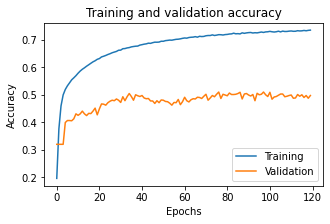

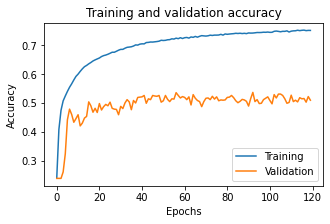

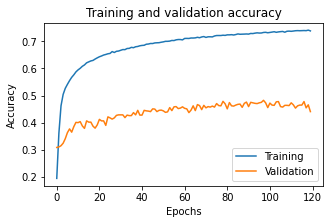

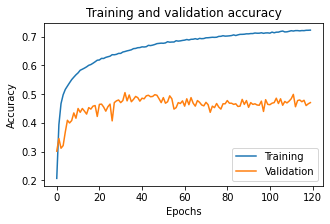

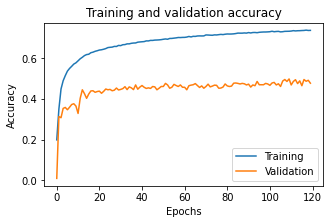

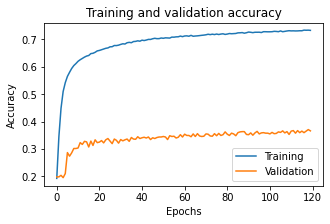

In [ ]:
'''Call the main routine for each fold'''
result_model = []
train_aug_indexes = {}

with tf.device('/gpu:0'):
    metric_names = ['accuracy','f1_weightedmacroavg','confusion_matrix','classification_report','printable_classification_report']
    evaluation_metrics, quantized_model_evaluation_metrics = {k:[] for k in metric_names}, {k:[] for k in metric_names}
    
    X,y = dataset_features.to_numpy(), dataset_labels.to_numpy()

    if USE_CROSS_VALIDATION:
        for foldidx,split_folds in enumerate(cv.split(X, y)): 
            if CUSTOM_PLAYER_K_FOLD:
                train_idx, test_idx, val_idx  = split_folds
            else:
                train_idx, test_idx = split_folds
                val_idx = None

            train_aug_idx = []  # Indexes of the augmented data that correspond to the current training split
            if USE_AUGMENTED_DATA: # Here we want to select the augmented data that corresponds to the current training split
                print('Selecting augmented data for fold',foldidx,'...')
                training_metadata = metadata.iloc[train_idx]
                training_sources_and_times = {tuple(k):True for k in training_metadata[['meta_audiofilePath','meta_onsetGroundTruthLabelTime']].values}
                
                for idx,source_aug,time_aug in  metadata_aug[['meta_augmentation_source','meta_onsetGroundTruthLabelTime']].itertuples():
                    if((source_aug,time_aug) in training_sources_and_times.keys()):
                        train_aug_idx.append(idx)
                assert len(train_aug_idx) > 0, "No augmented data found for the current training split"
                print('Found',len(train_aug_idx),'augmented samples for fold',foldidx)
            train_aug_indexes[foldidx] = train_aug_idx
            # TODO: wait there might be a bug here, we are not using the augmented data 
            result_model.append(main_routine(X, y,
                                             train_idx = train_idx,
                                             test_idx  = test_idx,
                                             val_idx   = val_idx,
                                             aug_data = None if not USE_AUGMENTED_DATA else (metadata_aug, features_aug, labels_aug, train_aug_idx),
                                             foldcount = foldidx+1,
                                             is_k_fold = USE_CROSS_VALIDATION,
                                             eval_metrics           = evaluation_metrics,
                                             quantized_eval_metrics = quantized_model_evaluation_metrics))        
    else:
        result_model = main_routine(X, y,
                                    eval_metrics           = evaluation_metrics,
                                    quantized_eval_metrics = quantized_model_evaluation_metrics,
                                    _val_split_size        = VAL_SPLIT_SIZE)

# Cross Validation average results

## Utilities for reports and metrics

In [ ]:
def report_average(reports):
    mean_dict = dict()
    for label in reports[0].keys():
        dictionary = dict()

        if label in 'accuracy':
            mean_dict[label] = sum(d[label] for d in reports) / len(reports)
            continue

        for key in reports[0][label].keys():
            dictionary[key] = sum(d[label][key] for d in reports) / len(reports)
        mean_dict[label] = dictionary

    return mean_dict

def classification_report_dict2print(report):
    ret = ""
    classes = list(report.keys())[0:-3]
    summary_metrics = list(report.keys())[-3:]
    longest_1st_column_name = max([len(key) for key in report.keys()])
    ret = ' ' * longest_1st_column_name
    ret += '  precision    recall  f1-score   support\n\n'

    METRIC_DECIMAL_DIGITS = 4
    metric_digits = METRIC_DECIMAL_DIGITS + 2 # add 0 and dot

    header_spacing = 1
    metrics = list(report[classes[0]].keys())
    longest_1st_row_name = max([len(key) for key in report[classes[0]].keys()]) + header_spacing

    for classname in classes:
        ret += (' '*(longest_1st_column_name-len(classname))) + classname + ' '
        for metric in metrics:
            if metric != "support":
                ret += (' '*(longest_1st_row_name-metric_digits))
                ret += "%.4f" % round(report[classname][metric],METRIC_DECIMAL_DIGITS)
            else:
                current_support_digits = len(str(int(report[classname][metric])))
                ret += (' '*(longest_1st_row_name-current_support_digits))
                ret += "%d" % round(report[classname][metric],0)
        ret += '\n'
    ret += '\n'

    # Accuracy
    ret += (' '*(longest_1st_column_name-len(summary_metrics[0]))) + summary_metrics[0] + ' '
    ret += 2* (' '*longest_1st_row_name)
    ret += (' '*(longest_1st_row_name-metric_digits))
    ret += "%.4f" % round(report["accuracy"],METRIC_DECIMAL_DIGITS)
    current_support_digits = len(str(int(report[summary_metrics[-1]]['support'])))
    ret += (' '*(longest_1st_row_name-current_support_digits))
    ret += "%d" % round(report[summary_metrics[-1]]['support'],0)
    ret += '\n'
  
  
    for classname in summary_metrics[1:]:
        ret += (' '*(longest_1st_column_name-len(classname))) + classname + ' '
        for metric in metrics:
            if metric != "support":
                ret += (' '*(longest_1st_row_name-metric_digits))
                ret += "%.4f" % round(report[classname][metric],METRIC_DECIMAL_DIGITS)
            else:
                current_support_digits = len(str(int(report[classname][metric])))
                ret += (' '*(longest_1st_row_name-current_support_digits))
                ret += "%d" % round(report[classname][metric],0)
        ret += '\n'
    ret += '\n'

    return ret

## Compute average

In [ ]:
if USE_CROSS_VALIDATION:
    assert len(evaluation_metrics['accuracy']) == K_SPLITS, "The number of accuracy values does not match the number of folds ({} != {})".format(len(evaluation_metrics['accuracy']),K_SPLITS)
    
    averaged_classification_reports = report_average(evaluation_metrics["classification_report"])
    macro_avg_f1_score = averaged_classification_reports["macro avg"]["f1-score"]
    average_fold_accuracy = averaged_classification_reports["accuracy"]
    printable_avg_report = classification_report_dict2print(averaged_classification_reports)
    qm_printable_avg_report = "Not performed"
    if TEST_QUANTIZATION:
        qm_printable_avg_report = classification_report_dict2print(report_average(quantized_model_evaluation_metrics["classification_report"]))
    metrics_to_save = {'macro avg f1-score' : macro_avg_f1_score,\
                       'average_fold_accuracy' : average_fold_accuracy,\
                       'avg_classification_report' : printable_avg_report,\
                       'avg_classification_report_for_quantized_model' : qm_printable_avg_report}
else:
    assert len(evaluation_metrics['accuracy']) == 1
    metrics_to_save = {}
    for metric in evaluation_metrics.keys():
        metrics_to_save[metric] = evaluation_metrics[metric][0]
    for metric in quantized_model_evaluation_metrics.keys():
        metrics_to_save['quantizedmod_'+str(metric)] = quantized_model_evaluation_metrics[metric][0]


# Save Model Info

In [ ]:
if SAVE_MODEL_INFO:
    current_dir = MODELFOLDER + "/" + RUN_NAME
    # %mkdir -p "$current_dir"
    os.makedirs(current_dir,exist_ok = True)

    save_model_info(result_model[0] if type(result_model) == list else result_model,
                    optimizer,
                    USE_CROSS_VALIDATION,K_SPLITS,
                    metrics_to_save,
                    current_dir)
else:
    print("RESULTS\n\n" + metrics_to_save)

# Train final model on the entire dataset

In [ ]:
run_dir = os.path.join(MODELFOLDER,RUN_NAME)
assert os.path.exists(run_dir)

In [ ]:
if TRAIN_FINAL_MODEL:
    use_early_stopping = False

    ### DEFINE MODEL
    final_model = define_model_architecture(len(CLASSES),_verbose = True)
    loss_fn = get_loss()

    ### Normalize data if needed
    if DO_NORMALIZE_DATA:
        scaler = SCALER_TO_USE
        X = scaler.fit_transform(X)

        # Save final scaler and parameters
        with open(os.path.join(run_dir,'scaler.pickle'),'wb') as sf:
            pickle.dump(scaler,sf)
        with open(os.path.join(run_dir,'info.txt'),'a') as infof:
            if type(SCALER_TO_USE) == MinMaxScaler:
                infof.write("The scaler used was sklearn.preprocessing MinMaxScaler\nScaler parameters:\n")

                infof.write('MinMaxScaler().data_min_: '        + str(SCALER_TO_USE.data_min_)+'\n')
                infof.write('MinMaxScaler().data_max_: '        + str(SCALER_TO_USE.data_max_)+'\n')
                infof.write('MinMaxScaler().data_range_: '      + str(SCALER_TO_USE.data_range_)+'\n')
                infof.write('MinMaxScaler().scale_: '           + str(SCALER_TO_USE.scale_)+'\n')
                infof.write('MinMaxScaler().n_samples_seen_: '  + str(SCALER_TO_USE.n_samples_seen_)+'\n')
            elif type(SCALER_TO_USE) == StandardScaler:
                infof.write("The scaler used was sklearn.preprocessing StandardScaler\nScaler parameters:\n")
                infof.write('StandardScaler().mean_: '          + str(SCALER_TO_USE.mean_)+'\n')
                infof.write('StandardScaler().var_: '           + str(SCALER_TO_USE.var_)+'\n')
                infof.write('StandardScaler().scale_: '         + str(SCALER_TO_USE.scale_)+'\n')
                infof.write('StandardScaler().n_samples_seen_: '+ str(SCALER_TO_USE.n_samples_seen_)+'\n')
            else:
                raise Exception("\"%s\" scaler not supported"%(SCALER_TO_USE))

    ### PREPARE DATA IN CASE OF A FIRST CONV LAYER IN THE NET
    if type(final_model.layers[0]) == tf.keras.layers.Conv1D:
        X_all = np.expand_dims(X,axis = 2) # Adapt data for Conv1d ([batch_shape, steps, input_dim] -> in our case indim = 1, steps = features, batchshape = train datset size)
    else:
        X_all = X

    ### COMPILE MODEL
    compile_model(final_model,optimizer,loss_fn,_verbose = True)

    ### SETUP TENSORBOARD
    tensorboard_callback = start_tensorboard(tb_dir,None)
    callbacks=[tensorboard_callback,]

    ### SETUP EARLY STOPPING (only if not in K-fold mode)
    if use_early_stopping:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=200))

    # * FIT MODEL *
    final_model.fit(X_all, y, epochs=args['epochs'],
                    callbacks=callbacks,
                    batch_size=args['batchsize'])

In [ ]:
final_model_dir = MODELFOLDER + "/" + RUN_NAME + "/finalModel"
# %mkdir -p "$final_model_dir"
os.makedirs(final_model_dir,exist_ok = True)

final_model.save(final_model_dir)

# Convert and save lite model (Non quantized)
convert2tflite(final_model_dir,model_name='final_model',quantization=None)
# Convert and save lite model (Dynamically quantized)
convert2tflite(final_model_dir,model_name='final_model_dynquant',quantization="dynamic")

INFO:tensorflow:Assets written to: ./output/CrossValidatedRun_20221222-182105/finalModel/assets


# Save the model for TF Lite
## *(Only if not a Cross Validated run)*

In [ ]:
# if USE_CROSS_VALIDATION is False:
#     model_path = MODELFOLDER + "/" + RUN_NAME
#     convert2tflite(model_path)                                                # standard TFLITE model
#     convert2tflite(model_path,model_name="model_partially_quantized",quantization="dynamic")   # Partial quantization  https://www.tensorflow.org/lite/performance/post_training_quantization#dynamic_range_quantization
    
#     quantization_dataset = X
#     if type(result_model.layers[0]) == tf.keras.layers.Conv1D:
#         quantization_dataset = np.expand_dims(X,axis = 2) # Adapt data for Conv1d
    
#     convert2tflite(model_path,model_name="model_float_fallback",quantization="float-fallback",dataset=quantization_dataset) # https://www.tensorflow.org/lite/performance/post_training_integer_quant#convert_using_float_fallback_quantization
#     convert2tflite(model_path,model_name="model_fully_quantized",quantization="full",dataset=quantization_dataset)          # FULL uint8 quantization https://www.tensorflow.org/lite/performance/post_training_quantization#full_integer_quantization

In [ ]:
# first_layer_is_conv = (type(result_model.layers[0]) == tf.keras.layers.Conv1D)

In [ ]:
# TEST_SAVED_MODEL = None
# # TEST_SAVED_MODEL = 'model.tflite'
# # TEST_SAVED_MODEL = 'model_partially_quantized.tflite'
# # TEST_SAVED_MODEL = 'model_float_fallback.tflite'
# # TEST_SAVED_MODEL = 'model_fully_quantized.tflite'
# # TEST_SAVED_MODEL = 'quant_aware_model.tflite'
# # TEST_SAVED_MODEL = 'saved_model.pb'
# verbose_test = False

# def test_generic_model(model_filename,model_path,X_test,Y_test,first_layer_is_conv,verbose_test = False):
#     if model_filename.split('.')[-1] == 'tflite':
#         y_pred = test_tflite_model(model_path+'/'+model_filename,X_test,y_test,first_layer_is_conv,verbose_test = verbose_test)
#         correct = np.count_nonzero((np.array(y_pred) == np.ravel(y_test)).astype(int))
#         total = np.shape(y_test)[0]
#         accuracy = round(correct/total,4)
#     elif model_filename.split('.')[-1] == 'pb':
#         accuracy = test_regulartf_model(model_path,X_test,y_test,first_layer_is_conv,verbose_test = verbose_test)
#     else:
#         raise ValueError("")

#     return accuracy

# if USE_CROSS_VALIDATION is False and TEST_SAVED_MODEL is not None:
#     assert np.max([len(ev_metric) for ev_metric in evaluation_metrics]) == K_SPLITS

#     target_accuracy = evaluation_metrics['accuracy'][0]
#     accuracy = test_generic_model(TEST_SAVED_MODEL,model_path,X_test,Y_test,first_layer_is_conv)

#     epsilon = 1e-4
#     EQUAL_ACCURACY = abs(target_accuracy - accuracy) < epsilon

#     print("accuracy: " + str(accuracy))

#     if EQUAL_ACCURACY:
#         print("Accuracy of the original model and the saved TF model correspond(on same test set)")
#     else:
#         raise ValueError('Accuracy does not match target (Target: '+str(target_accuracy)+' but got '+str(accuracy)+' instead)')
# else:
#     print("TF model testing is disabled")

# Quantization aware fine-tuning

In [ ]:
# #################################################
# PERFORM_QUANZATION_AWARE_TRAINING = False       #
# #################################################
# if PERFORM_QUANZATION_AWARE_TRAINING:
#     pip_install('tensorflow_model_optimization')

In [ ]:
# if PERFORM_QUANZATION_AWARE_TRAINING:
#     imported_model = tf.keras.models.load_model(model_path)

#     import tensorflow_model_optimization as tfmot

#     quantize_model = tfmot.quantization.keras.quantize_model

#     # q_aware stands for for quantization aware.
#     q_aware_model = None
#     q_aware_model = quantize_model(imported_model)

#     # `quantize_model` requires a recompile.
#     _,loss_fn = define_model_architecture(len(CLASSES),_verbose = True)  # Get only the loss function
#     compile_model(q_aware_model,optimizer,loss_fn,_verbose = True)  # Recompile the quantization aware model

#     q_aware_model.summary()

In [ ]:
# if PERFORM_QUANZATION_AWARE_TRAINING:
#     tb_dir = "logs2/fit/"
#     %tensorboard --logdir $tb_dir

In [ ]:
# if PERFORM_QUANZATION_AWARE_TRAINING:
#     finetuning_epochs = 50
#     tensorboard_callback = start_tensorboard(tb_dir,None)

#     q_history = q_aware_model.fit(X_train, y_train, epochs=finetuning_epochs, validation_data = (X_valid,y_valid),
#                                 callbacks=[tensorboard_callback],
#                                 batch_size=args['batchsize'])

In [ ]:
# if PERFORM_QUANZATION_AWARE_TRAINING:
#     quant_model_path = MODELFOLDER + "/" + RUN_NAME + "/quant_aware_model.tflite"

#     converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
#     converter.optimizations = [tf.lite.Optimize.DEFAULT]

#     quantized_tflite_model = converter.convert()

#     with tf.io.gfile.GFile(quant_model_path, 'wb') as f:
#         f.write(quantized_tflite_model)

## Rename current output folder by prefixing the accuracy value

In [ ]:
if FEATURE_WINDOW_SIZE == FeatureWindowSize.s4800_SAMPLES_100ms:
    window_folder = '100ms'
elif FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms:
    window_folder = '14.67ms'
else:
    raise ValueError('Invalid FeatureWindowSize "%s"'%FeatureWindowSize.name)
# make window folder
window_folder = os.path.join(os.path.dirname(run_dir),window_folder)
if not os.path.exists(window_folder):
    os.mkdir(window_folder)
problem_folder = os.path.join(window_folder,classification_task.value[1])
if not os.path.exists(problem_folder):
    os.mkdir(problem_folder)

In [ ]:
if os.path.exists(os.path.join(run_dir,'info.txt')):
    metrics_prefix = 'c_' if 'CrossValidated' in os.path.basename(run_dir) else ''

    metrics_prefix += 'maf1_%.4f_acc_%.4f_'%(round(metrics_to_save['macro avg f1-score'],4),round(metrics_to_save['average_fold_accuracy'],4))

    window_prefix = ''
    if FEATURE_WINDOW_SIZE == FeatureWindowSize.s4800_SAMPLES_100ms:
        window_prefix = 'z100ms_'
    elif FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms:
        pass
    else:
        raise ValueError('Invalid FeatureWindowSize "%s"'%FeatureWindowSize.name)


    problem_prefix = classification_task.value[1]+'_'
        
    newfoldername = os.path.join(problem_folder,window_prefix+problem_prefix+metrics_prefix+os.path.basename(run_dir))
    # print('Renaming "'+run_dir+'" to "'+newfoldername+'"')
    os.rename(run_dir,newfoldername)
    run_dir = newfoldername
else:
    errfoldername = os.path.join(os.path.dirname(run_dir),'ERR_'+os.path.basename(run_dir))
    os.rename(run_dir,errfoldername)
    run_dir = errfoldername

## Testing with extra test data
This data was extracted from extra recordings, made to test the system in a real life scenario.  
Here we test only to veryfy that everything is working here, before making a shift to the real life test

In [ ]:
if FEATURE_WINDOW_SIZE == FeatureWindowSize.s4800_SAMPLES_100ms:
    TEST_WITH_EXTRA_DATA = False
elif FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms:
    TEST_WITH_EXTRA_DATA = True # Heep in mind that TRAIN_FINAL_MODEL should be True too
else:
    raise ValueError('Invalid FeatureWindowSize "%s"'%FeatureWindowSize.name)

In [ ]:
if TRAIN_FINAL_MODEL and TEST_WITH_EXTRA_DATA:
    """ Load the test data """

    TEST_DATA_FILE_PATH = os.path.join(DATAFOLDER,'20221011_110715_test_onlycorrectdetections.pickle')
    print("Loading test data from pickle...")
    with open(TEST_DATA_FILE_PATH,'rb') as pf:
        testdataset = pickle.load(pf)
    testdataset.sort_values(['meta_expressive_technique_id','meta_audiofilePath'],inplace = True)
    print('Done.')
    # If this fails, the dataset has changed from the last time the program was run successfully (CHECK THE DATA!!!)
    assert testdataset.shape == (754,507)
    # display(testdataset)


    """ Drop unused features (like the train/test dataset) """

    drop_unused_features(testdataset,inplace=True)
    assert testdataset.shape == (754,504)


    """ Divide the test data into metadata, features and labels (like the train/test dataset) """

    test_metadata, test_features, test_labels = divide_dataset(testdataset)
    assert test_metadata.shape[0] == test_features.shape[0] == test_labels.shape[0] == 754
    assert test_metadata.shape[1] == 9
    assert test_features.shape[1] == 495

    """ Filter the dataset according to the task """
    # This might mean removing samples or renaming classes
    test_features,test_labels,test_metadata = filter_dataset(test_features.copy(),test_labels.copy(),test_metadata.copy(),classification_task)



    """ Apply the feature selection computed for the train/test set (like the train/test dataset) """

    test_features = test_features.copy().loc[:,selected_features]

    if len(selected_features) != AUTO_FEATURE_NUMBER:
        raise Exception('The number of selected_features ('+str(len(selected_features))+') is not the same as AUTO_FEATURE_NUMBER ('+str(AUTO_FEATURE_NUMBER)+'). Check the code.')

    if test_features.shape[1] != AUTO_FEATURE_NUMBER:
        raise Exception('The number of features in the test dataset ('+str(test_features.shape[1])+') is different from the number of features in the train/test dataset ('+str(AUTO_FEATURE_NUMBER)+')')

In [ ]:
if TRAIN_FINAL_MODEL and TEST_WITH_EXTRA_DATA:
    extra_test_x = test_features.to_numpy()
    extra_test_y = test_labels.to_numpy()

    

    if DO_NORMALIZE_DATA:
        # This scaler was "learned" a few cells above on the whole train/test dataset (obviously exluding the etra-test data)
        extra_test_x = scaler.transform(extra_test_x)

    if type(final_model.layers[0]) == tf.keras.layers.Conv1D:
        extra_test_x = np.expand_dims(extra_test_x,axis = 2) # Adapt data for Conv1d ([batch_shape, steps, input_dim] -> in our case indim = 1, steps = features, batchshape = train datset size)

    y_true = np.squeeze(extra_test_y)
    y_pred = np.argmax(final_model(extra_test_x),axis=1)
    cm_acc, f1mw, cm_conf_matrix, cm_classf_report, cm_printable_classf_report = compute_metrics(y_true, y_pred, _verbose=False)

    with open(os.path.join(run_dir,'info.txt'),'a') as infof:
        infof.write('______________________________________________________________________________________________________________________________________________________\n\n\n')
        infof.write('+----------------------------------------------------------------+\n')
        infof.write('| Results obtained on extra test recordings with the FINAL MODEL |\n')
        infof.write('+----------------------------------------------------------------+\n\n')
        infof.write('Extra-test-Accuracy: '+str(cm_acc)+'\n\n')
        infof.write('Extra-test-F1 Score (weighted average): '+str(f1mw)+'\n\n')
        infof.write('Extra-test-ConfusionMatrix: \n'+str(cm_conf_matrix)+'\n\n')
        infof.write('Extra-test-Report: \n'+str(cm_printable_classf_report)+'\n\n')

In [ ]:
print('*--* Training successfully completed. *--*')
print("Data at",run_dir)

*--* Training successfully completed. *--*
Data at ./output/14.67ms/full/full_c_maf1_0.2200_acc_0.4684_CrossValidatedRun_20221222-182105


In [ ]:
import requests

def send_to_telegram(message):
    apiToken = 'apiKeyHere'
    chatID = 'chatIDHere'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        # print(response.text)
    except Exception as e:
        print(e)

# send_to_telegram('Training completed in folder ' + run_dir)


# check if 'best_notified_accyracy_yet.txt' exists
# if it does, read the value, compare to the current and notify via telegram if the current is better
# if it doesn't, create it and write the current value

def save_and_notify_if_greater(newvalue, metricfilepath, metric_name):
    BA_FILE = metricfilepath
    if os.path.exists(BA_FILE):
        with open(BA_FILE) as f:
            best_notified_metric_yet = float(f.readline())
    else:
        best_notified_metric_yet = 0.0

    if newvalue > best_notified_metric_yet:
        message = str(round(newvalue,4)) + '\nfrom run in folder ' + run_dir
        with open(BA_FILE,'w') as f:
            f.write(message)
        send_to_telegram('New best '+str(metric_name)+': '+message)

save_and_notify_if_greater(metrics_to_save['average_fold_accuracy'], os.path.join(MODELFOLDER,'best_accuracy_yet_notified.txt'), 'Accuracy')
save_and_notify_if_greater(metrics_to_save['macro avg f1-score'], os.path.join(MODELFOLDER,'best_maf1_yet_notified.txt'), 'Macro Average F1-Score')